# Третье практическое задание. Реализация дропаута в рекуррентных нейронных сетях
Практикум на ЭВМ для 317 группы, весна 2021

#### Фамилия, имя:

Дата выдачи: 3 апреля 00:01

Мягкий дедлайн: 17 апреля 00:01

Данное задание будет состоять из двух частей:
1. Применение рекуррентной сети для решения задачи классификации текста. Более конкретно -- предсказания рейтинга отзыва фильма.
2. Простейшая лингвистическая модель для генерации текста на основе LSTM.

При выполнении задания вы обучите LSTM с разным уровнем "коробочности", а также познакомитесь с различными способами применения DropOut к рекуррентным архитектурам. В рекуррентных архитектурах вариантов, куда можно наложить бинарную маску шума, гораздо больше, чем в нейросетях прямого прохода.

Во второй части вы попробуете реализовать простейший рекуррентный декодер для генерации текстов.

Задание сделано так, чтобы его можно было выполнять на CPU, однако RNN - это ресурсоёмкая вещь, поэтому на GPU с ними работать приятнее. Можете попробовать использовать [https://colab.research.google.com](https://colab.research.google.com) - бесплатное облако с GPU.

**Для корректного отображения картинок, вам может понадобится сделать ноутбук доверенным (Trusted) в правом верхнем углу**

# Часть 0. Загрузка и предобработка данных. (1 балл)

## Рекомендуемые гиперпараметры

In [352]:
max_length = 200
top_n_words = 5000

hidden_dim = 128
embedding_dim = 32

num_epochs = 15
batch_size = 64
learning_rate = 1e-3

Первое, что нужно сделать -- скачать, предобработать данные и организовать их таким образом, чтобы их можно было подавать в нейронную сеть.

Для обеих частей задания мы будем использовать [**Large Movie Review Dataset**](https://ai.stanford.edu/~amaas/data/sentiment/).

## Загрузка и предобработка данных

Загрузите данные по ссылке выше. (**tip**: используйте `wget`)

In [353]:
pip install wget

In [354]:
import wget

In [355]:
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

In [356]:
data_file = wget.download(url)

In [357]:
type(data_file)

str

In [358]:
import tarfile

Распакуйте скачанные данные в папку `aclImdb` (**tip:** используйте `tar`)

In [359]:
tar = tarfile.open(data_file)
tar.extractall(path='.')
tar.close()

Посмотрите в файле `./aclImdb/README` как организованы данные

In [360]:
! cat ./aclImdb/README

Large Movie Review Dataset v1.0

Overview

This dataset contains movie reviews along with their associated binary
sentiment polarity labels. It is intended to serve as a benchmark for
sentiment classification. This document outlines how the dataset was
gathered, and how to use the files provided. 

Dataset 

The core dataset contains 50,000 reviews split evenly into 25k train
and 25k test sets. The overall distribution of labels is balanced (25k
pos and 25k neg). We also include an additional 50,000 unlabeled
documents for unsupervised learning. 

In the entire collection, no more than 30 reviews are allowed for any
given movie because reviews for the same movie tend to have correlated
ratings. Further, the train and test sets contain a disjoint set of
movies, so no significant performance is obtained by memorizing
movie-unique terms and their associated with observed labels.  In the
labeled train/test sets, a negative review has a score <= 4 out of 10,
and a positive review has a scor

In [361]:
! cat ./aclImdb/train/pos/10003_8.txt

This is not the typical Mel Brooks film. It was much less slapstick than most of his movies and actually had a plot that was followable. Leslie Ann Warren made the movie, she is such a fantastic, under-rated actress. There were some moments that could have been fleshed out a bit more, and some scenes that could probably have been cut to make the room to do so, but all in all, this is worth the price to rent and see it. The acting was good overall, Brooks himself did a good job without his characteristic speaking to directly to the audience. Again, Warren was the best actor in the movie, but "Fume" and "Sailor" both played their parts well.

In [362]:
test_data_path = './aclImdb/test/'
train_data_path = './aclImdb/train/'

In [363]:
import os
from functools import partial
from collections import defaultdict

import nltk
nltk.download('stopwords')

import regex
import numpy as np

import torch
import torchtext
from torch.utils.data import Dataset, DataLoader

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Стандартной предобработкой данных является токенизация текстов. Полученные токены можно будет закодировать и затем подавать на вход нейронной сети. Ключевым моментом, который влияет на скорость работы нейросети и её размер в памяти -- размер словаря, используемого при токенизации. Для задачи классификации мы можем убрать часть слов (стоп слова, редкие слова), ускорив обучение без потери в качестве.

In [364]:
STOPWORDS = nltk.corpus.stopwords.words('english')

Реализуйте функцию для токенизации текста. Выполнять токенизацию можно по-разному, но в данном задании предлагается это делать следующим образом:
1. Привести текст к нижнему регистру
2. Убрать html разметку из текстов (`<br />`)
3. Убрать все символы кроме латинских букв
4. Разбить строку по пробелам
5. Убрать стоп слова

In [365]:
import re
def tokenize(text):
    """
    :param str text: Input text 
    :return List[str]: List of words
    """
    # YOUR CODE HERE
    text = text.lower()
    text = text.replace('<br />', '')
    text = re.sub(r"[^a-zA-Z]+", " ", text)
    text = text.split(' ')
    text = [word for word in text if word not in STOPWORDS]
    return text[1:-1]

In [366]:
tokenize('1Hello  FFF fF 343     dfd 3ee4 reds  <br />  words!  ! <br /> ')

['hello', 'fff', 'ff', 'dfd', 'ee', 'reds', 'words']

In [367]:
tokenize('1. Hello <br /> words!! <br />')

['hello', 'words']

Теперь мы можем создать словарь, с помощью которого мы будем численно кодировать токены из текста и наоборот.

Удобной обёрткой для создания словарей является класс `torchtext.vocab.Vocab`.

In [368]:
torchtext.vocab.Vocab??

Чтобы создать такой словарь, сначала нужно создать словарь со всеми токенами в тексте и их частотами встречаемости:

In [369]:
counter = defaultdict(int)

for path in ['./aclImdb/test/neg', './aclImdb/test/pos', './aclImdb/train/neg', './aclImdb/train/pos']:
    for file_path in os.listdir(path):
        text = open(os.path.join(path, file_path), 'r', encoding='utf-8', errors='ignore').read().strip()
        for token in tokenize(text):
            counter[token] += 1

Для работы с текстами нам необходимо зарезервировать два специальных токена:
1. `<pad>` для токена означающего паддинг
2. `<unk>` для токенов, которые отсутствуют в словаре

In [370]:
specials = ['<pad>', '<unk>']
for special in specials:
    counter[special] = 0

In [371]:
counter['<pad>'], counter['<unk>']

(0, 0)

In [372]:
top_n_words

5000

In [373]:
len(counter)

100898

*Создайте* словарь из словаря частот `counter`. Наименьшие id отдайте под специальные токены. Отбросьте низкочастотные слова, оставив только `top_n_words` слов

In [374]:
# YOUR CODE HERE
vocab = torchtext.vocab.Vocab(counter, max_size = top_n_words, specials = specials)

In [375]:
vocab.lookup_indices(['<pad>', '<unk>'])

[0, 1]

In [376]:
vocab.lookup_indices(['<pad>', '<unk>'])

[0, 1]

In [377]:
vocab.lookup_indices(['this', 'film', 'was', 'awful'])

[1, 3, 1, 254]

In [378]:
type(vocab)

torchtext.vocab.Vocab

In [379]:
len(vocab)

5002

In [380]:
len(vocab.itos)

5002

In [381]:
#vocab.lookup_indices(vocab)

Теперь мы готовы создать обёртку-датасет для наших данных. 

Необходимо добавить несколько опции, которые понадобятся во второй части задания:
1. Ограничение на максимальную длину текста в токенах. Если текст оказывается длиннее, то последние токены отбрасываются
2. Возможность добавить в специальные токены `<sos>`, `<eos>` в начало и конец токенизированного текста
    
**tips:**
1. Обратите особое внимание, что у длинных текстов не должен обрезаться паддинг
2. В исходных данных рейтинг закодирован в названии файла в виде числа от 1 до 10. Для удобства, вычтите 1, чтобы рейтинг был от 0 до 9

In [382]:
s = '123'
int(s[0])

1

In [383]:
class LargeMovieReviewDataset(Dataset):
    def __init__(self, data_path, vocab, max_len, pad_sos=False, pad_eos=False):
        """
        :param str data_path: Path to folder with one of the data splits (train or test)
        :param torchtext.vocab.Vocab vocab: dictionary with lookup_indices method
        :param int max_len: Maximum length of tokenized text
        :param bool pad_sos: If True pad sequence at the beginning with <sos> 
        :param bool pad_eos: If True pad sequence at the end with <eos>         
        """
        super().__init__()
        
        self.pad_sos = pad_sos
        if self.pad_sos:
            self.sos_id = vocab.lookup_indices(['<sos>'])[0]
        self.pad_eos = pad_eos
        if self.pad_eos:
            self.eos_id = vocab.lookup_indices(['<eos>'])[0]
        
        self.vocab = vocab
        self.max_len = max_len
        self.data_path = data_path
        self.negative_path = os.path.join(data_path, 'neg')
        self.positive_path = os.path.join(data_path, 'pos')
        
        self.negative_paths = []
        self.positive_paths = []

        for file_path in os.listdir(self.negative_path):
            self.negative_paths.append(os.path.join(self.negative_path, file_path))

        for file_path in os.listdir(self.positive_path):
            self.positive_paths.append(os.path.join(self.positive_path, file_path))
        
        self.texts = []
        self.tokens = []
        self.ratings = []
        self.labels = [0] * len(self.negative_paths) + [1] * len(self.positive_paths)
        
        # Read each file in data_path, tokenize it, get tokens ids, its rating and store
        for path in self.negative_paths + self.positive_paths:
            # YOUR CODE HERE
            text = open(path, 'r', encoding='utf-8', errors='ignore').read().strip()
            self.texts += [text]
            tokenize_text = tokenize(text)[:max_length]
            self.tokens += [self.vocab.lookup_indices(tokenize_text)]
            if path[-6] == '_':
              self.ratings += [int(path[-5])- 1]
            else:
              self.ratings += [9]

        
    def __getitem__(self, idx):
        """
        :param int idx: index of object in dataset
        :return dict: Dictionary with all useful object data 
            {
                'text' str: unprocessed text,
                'label' torch.tensor(dtype=torch.long): sentiment of the text (0 for negative, 1 for positive)
                'rating' torch.tensor(dtype=torch.long): rating of the text
                'tokens' torch.tensor(dtype=torch.long): tensor of tokens ids for the text
                'tokens_len' torch.tensor(dtype=torch.long): number of tokens
            }
        """
        # YOUR CODE HERE
        # Do not forget to add padding if needed!
        if self.pad_sos:
          (self.tokens[idx]).insert(0, self.sos_id)
        if self.pad_eos:
          (self.tokens[idx]).append(self.eos_id)
        l = len(self.tokens[idx])
        d = {'text': self.texts[idx], 'label': torch.tensor(self.labels[idx], dtype=torch.long), 'rating' :torch.tensor(self.ratings[idx], dtype=torch.long), 'tokens': torch.tensor(self.tokens[idx], dtype=torch.long), 'tokens_len': torch.tensor(l,dtype=torch.long)}
        return d
    def __len__(self):
        """
        :return int: number of objects in dataset 
        """
        # YOUR CODE HERE
        return len( self.texts)

Создайте датасеты для тестовой и обучающей выборки. 

Обратите внимание, что для задачи классификации нам не потребуется паддинг с помощью `<sos>`, `<eos>`. 

Не забудьте обрезать длинные тексты, передав параметр `max_length`.

In [384]:
# YOUR CODE HERE
test_dataset = LargeMovieReviewDataset(test_data_path, vocab, max_length)
train_dataset = LargeMovieReviewDataset(train_data_path, vocab, max_length)

Посмотрим, как выглядит объект в датасете:

In [385]:
test_dataset[-1]

{'label': tensor(1),
 'rating': tensor(8),
 'text': "'The Dresser' is one of those films which are so perfect you really struggle to find something not to like about them. Written by Ronald Harwood (himself a former dresser to the legendary Donald Wolfit), it sparkles with energy and true love of life behind the footlights.<br /><br />As 'Sir', the overbearing actor and main focus of the play, Albert Finney is a joy to watch - whether complaining about the lack of a storm during the 'blow, winds ...' bit of 'King Lear' or chatting to his faithful stage manager, Madge (Eileen Atkins, good as ever) about the old times. As Norman, his camp dresser, Tom Courtenay gives a fabulous performance, wiggling around at the beck and call of 'Lear', collecting a bottle to go at the pub, or bitchily disparaging the former Fool, Mr Davenport-Scott (often mentioned, but never seen!).<br /><br />In an engaging support cast, there's Edward Fox as Oxenby (a typical arrogant second lead), Zena Walker as he

In [386]:
test_dataset[0]

{'label': tensor(0),
 'rating': tensor(1),
 'text': 'So what is one to do if you are a porno star with fading looks? I know, become a pop star! This documentary - and I use the term loosely - follows the trials and tribulations of Colton as he tries to transform himself from a gay porn star into a singer of electronic (read: dance) music. I only wish Mr Ford\'s voice was as muscular as his arms...sorry to say his vocals are painfully thin. There isn\'t much interesting going on here but Mr Ford and friends are eye candy.<br /><br />See him record a song that sounds exactly like every other mindless dance tune. See him travel to New York to make "connections." See him go back to L.A. with little success. See yourself look in the mirror and ask, " Why am I wasting time watching this mess?"',
 'tokens': tensor([3617,  205,    1,  174,   42,  298, 1382,  205,  507,  237, 2460, 3385,
          948,    1,    1,    1,  377,    1,  737, 1319,  205, 1643,    1,  239,
          711,  100,  505, 

In [387]:
len(test_dataset)

25000

Теперь нам нужно создать `DataLoader` для наших данных. `DataLoader` умеет из коробки объединять список объектов из датасета в один батч, даже когда датасет возвращает словарь тензоров. Однако, это работает только в случае когда все эти тензоры имеют один и тот же размер во всех батчах. В нашем случае, это не так, так как разные тексты могут иметь разную длину.

Чтобы обойти эту проблему у `DataLoader` есть параметр `collate_fn`, который позволяет задать функцию для объединения списка объектов в один батч.

Чтобы объединить несколько тензоров разной длины в один можно использовать функцию `torch.nn.utils.rnn.pad_sequence`

Обратите внимание на её аргументы:
1. `batch_first` определяет по какой оси "складывать" тензоры. Предпочтительнее использовать `batch_first=False` так как это может упростить выполнение задания в дальнейшем 
2. `padding_value` -- число, которое будет использоваться в качестве паддинга, чтобы сделать все тензоры одинаковой длины

In [388]:
torch.nn.utils.rnn.pad_sequence([
    torch.tensor([1, 2, 3]),
    torch.tensor([4, 5]),
    torch.tensor([6, 7, 8, 9])
], batch_first=False, padding_value=-1)

tensor([[ 1,  4,  6],
        [ 2,  5,  7],
        [ 3, -1,  8],
        [-1, -1,  9]])

In [389]:
def collate_fn(batch, padding_value, batch_first=False):
    """
    :param List[Dict] batch: List of objects from dataset
    :param int padding_value: Value that will be used to pad tokens
    :param bool batch_first: If True resulting tensor with tokens must have shape [B, T] otherwise [T, B]
    :return dict: Dictionary with all data collated
        {
            'ratings' torch.tensor(dtype=torch.long): rating of the text for each object in batch
            'labels' torch.tensor(dtype=torch.long): sentiment of the text for each object in batch
            
            'texts' List[str]: All texts in one list
            'tokens' torch.tensor(dtype=torch.long): tensor of tokens ids padded with @padding_value
            'tokens_lens' torch.tensor(dtype=torch.long): number of tokens for each object in batch
        }
    """
    # YOUR CODE HERE
    tenz_ratings = []
    tenz_labels = []
    tenz_texts = []
    tenz_tokens = []
    tenz_tokens_lens = []
    for batch_curr in batch:
      tenz_ratings.append(batch_curr['rating'])
      tenz_labels.append(batch_curr['label'])
      tenz_texts.append(batch_curr['text'])
      tenz_tokens.append(batch_curr['tokens'])
      tenz_tokens_lens.append(batch_curr['tokens_len'])

    tenz_tokens = torch.nn.utils.rnn.pad_sequence(tenz_tokens, batch_first = batch_first, padding_value = padding_value)
    d = {'texts': tenz_texts, 'labels': torch.tensor(tenz_labels, dtype=torch.long), 'ratings' :torch.tensor(tenz_ratings, dtype=torch.long), 'tokens': torch.tensor(tenz_tokens, dtype=torch.long), 'tokens_lens': torch.tensor(tenz_tokens_lens,dtype=torch.long)}
    return d

Создайте даталоадеры с использованием `collate_fn`.

**tips**:
1. Передать в `collate_fn` правильное значение паддинга можно, например, с помощью `functools.partial`
2. Если вы работаете в Google Colab, то, возможно, вам будет необходимо установить `num_workers=0` во избежание падения ноутбука.

In [390]:
# YOUR CODE HERE
from functools import partial
part = partial(collate_fn, padding_value = 0, batch_first = False)  
test_dataloader = DataLoader(test_dataset, collate_fn=part, batch_size=batch_size, shuffle=True)
train_dataloader = DataLoader(train_dataset, collate_fn=part, batch_size=batch_size, shuffle=True)

In [391]:
 #padding_value = 0

Посмотрим на какой-нибудь батч:

In [392]:
batch = next(iter(test_dataloader))
batch.keys(), batch['labels'], batch['ratings'], batch['tokens'], batch['tokens_lens']

(dict_keys(['texts', 'labels', 'ratings', 'tokens', 'tokens_lens']),
 tensor([1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1,
         0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0,
         0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0]),
 tensor([6, 0, 1, 0, 6, 0, 0, 0, 9, 3, 9, 1, 1, 7, 9, 7, 8, 1, 2, 3, 3, 7, 8, 6,
         0, 1, 1, 6, 0, 9, 7, 3, 7, 0, 3, 6, 7, 9, 8, 3, 8, 3, 7, 9, 8, 3, 7, 3,
         2, 7, 8, 9, 0, 0, 7, 0, 2, 3, 8, 0, 6, 8, 1, 0]),
 tensor([[ 104,  418,   11,  ...,    1,  588, 4161],
         [ 663,   58,    3,  ...,    1,  462, 1299],
         [   2,  312, 4560,  ...,   85,  952,  724],
         ...,
         [   0,    0,    0,  ...,    0, 4267,    0],
         [   0,    0,    0,  ...,    0,    1,    0],
         [   0,    0,    0,  ...,    0,  766,    0]]),
 tensor([ 40,  59,  75, 157,  56,  83,  80,  61,  73, 101, 200,  66, 200, 144,
         200,  38, 108,  53,  51,  58,  28,  65,  66,  56,  46,  84, 200,  5

In [393]:
test_dataloader

# Часть 1. Классификация текстов. (6 баллов)

## Сборка и обучение RNN в pytorch (2 балла)

Создадим переменные для device-agnostic кода:

In [394]:
dtype, device, cuda_device_id = torch.float32, None, 0
os.environ["CUDA_VISIBLE_DEVICES"] = '{0}'.format(str(cuda_device_id) if cuda_device_id is not None else '')
if cuda_device_id is not None and torch.cuda.is_available():
    device = 'cuda:{0:d}'.format(0)
else:
    device = torch.device('cpu')
print(f'Using device: {device}, dtype: {dtype}')

Using device: cuda:0, dtype: torch.float32


Наша нейросеть будет обрабатывать входную последовательность по словам (word level). Мы будем использовать простую и стандартную рекуррентную архитектуру для классификации:
1. Слой представлений, превращающий id токена в вектор-ембеддинг этого слова
2. Слой LSTM
3. Полносвязный слой, предсказывающий выход по последнему скрытому состоянию

Ниже дан код для сборки и обучения нашей нейросети.

Допишите класс-обёртку над LSTM для задачи классификации. 
**Не используйте циклы.**

**Для каждого тензора в функции `forward` подпишите в комментарии его размеры**

In [395]:
import torch
import torch.nn as nn
class RNNClassifier(torch.nn.Module):
    def __init__(
        self, embedding_dim, hidden_dim, output_size, vocab,
        rec_layer=torch.nn.LSTM, dropout=None, **kwargs
    ):
        super().__init__()

        self.dropout = dropout
        
        self.vocab = vocab
        self.hidden_dim = hidden_dim
        self.output_size = output_size
        self.embedding_dim = embedding_dim
        
        # Create a simple lookup table that stores embeddings of a fixed dictionary and size.
        #    Use torch.nn.Embedding. Do not forget specify padding_idx!
        # YOUR CODE HERE

        self.word_embeddings = torch.nn.Embedding(len(self.vocab), embedding_dim = self.embedding_dim, padding_idx=0)
        
        if dropout is not None:
            self.rnn = rec_layer(self.embedding_dim, self.hidden_dim, dropout=self.dropout, **kwargs)
        else:
            self.rnn = rec_layer(self.embedding_dim, self.hidden_dim, **kwargs)
        
        # Create linear layer for classification
        # YOUR CODE HERE


        self.output = nn.Linear(self.hidden_dim, self.output_size)
        #m = nn.LogSoftmax(dim = 1)
        #self.output = m(self.output)
    
    def forward(self, tokens, tokens_lens):
        """
        :param torch.tensor(dtype=torch.long) tokens: Batch of texts represented with tokens.
        :param torch.tensor(dtype=torch.long) tokens_lens: Number of non-padding tokens for each object in batch.
        :return torch.tensor(dtype=torch.long): Vector representation for each sequence in batch
        """
        # Evaluate embeddings
        # YOUR CODE HERE
        embed = self.word_embeddings(tokens) # len(vocab.stoi), batch_size, embedding_dim
        #print("embed", embed.shape)

        # Make forward pass through recurrent network
        # YOUR CODE HERE
        lstm_aft_emb = self.rnn(embed)[0]  # len(vocab.stoi), batch_size, hidden_dim
        #print('lstm_aft_emb', lstm_aft_emb.shape)
        exit_sell = lstm_aft_emb[tokens_lens - 1, torch.arange(lstm_aft_emb.shape[1])]
        #print('exit_sell', exit_sell.shape)
        # Pass output from rnn to linear layer 
        # Note: each object in batch has its own length 
        #     so we must take rnn hidden state after the last token for each text in batch
        # YOUR CODE HERE
        
        fin_res = self.output(exit_sell) # batch_size, output_dim
        #print('fin_res', fin_res.shape)
        return fin_res



[Исходный код LSTM](http://pytorch.org/docs/master/_modules/torch/nn/modules/rnn.html#LSTM)

Допишите функции для обучения и оценки модели:

**tip:**
1. В функции `evaluate` при подсчёте метрик учитывайте, что батчи могут иметь разный размер. (в частности последний батч)

In [396]:
def train_epoch(dataloader, model, loss_fn, optimizer, device):
    model.train()
    for idx, data in enumerate(dataloader):
        # 1. Take data from batch
        # 2. Perform forward pass
        # 3. Evaluate loss
        # 4. Make optimizer step
        # YOUR CODE HERE
        optimizer.zero_grad()

        token = data['tokens'].to(device)
        tokens_len = data['tokens_lens'].to(device)
        lstm_model = model.forward(token, tokens_len).to('cpu')
        loss = loss_fn(lstm_model, data['ratings'])

        loss.backward()
        optimizer.step()
    
def evaluate(dataloader, model, loss_fn, device):
    model.eval()
    
    total_loss = 0.0
    total_accuracy = 0.0
    with torch.no_grad():
        for idx, data in enumerate(dataloader):
            # 1. Take data from batch
            # 2. Perform forward pass
            # 3. Evaluate loss
            # 4. Evaluate accuracy
            # YOUR CODE HERE
            token = data['tokens'].to(device)
            tokens_len = data['tokens_lens'].to(device)
            lstm_model = model.forward(token, tokens_len).to('cpu')
            loss = loss_fn(lstm_model, data['ratings'])

            total_loss += loss
            total_accuracy += (lstm_model.argmax(axis =1) ==  data['ratings']).to(float).sum()

    return total_loss / len(dataloader.dataset), total_accuracy / len(dataloader.dataset)
    

def train(
    train_loader, test_loader, model, loss_fn, optimizer, device, num_epochs
):
    test_losses = []
    train_losses = []
    test_accuracies = []
    train_accuracies = []
    for epoch in range(num_epochs):
        train_epoch(train_loader, model, loss_fn, optimizer, device)
        
        train_loss, train_acc = evaluate(train_loader, model, loss_fn, device)
        train_accuracies.append(train_acc)
        train_losses.append(train_loss)
        
        test_loss, test_acc = evaluate(test_loader, model, loss_fn, device)
        test_accuracies.append(test_acc)
        test_losses.append(test_loss)
        
        print(
            'Epoch: {0:d}/{1:d}. Loss (Train/Test): {2:.3f}/{3:.3f}. Accuracy (Train/Test): {4:.3f}/{5:.3f}'.format(
                epoch + 1, num_epochs, train_losses[-1], test_losses[-1], train_accuracies[-1], test_accuracies[-1]
            )
        )
    return train_losses, train_accuracies, test_losses, test_accuracies

Создадим модель:

In [46]:
model = RNNClassifier(
    embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_size=10, vocab=vocab,
    rec_layer=torch.nn.LSTM, dropout=None
).to(device)

Создадим класс для подсчёта функции потерь и оптимизатор:

In [47]:
loss_fn = torch.nn.CrossEntropyLoss(reduction='sum') # sum mean
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Попробуем обучить модель:

**Сохраните все метрики и время работы модели. Это потребуется в конце первой части для построения графиков обучения и сравнения времени работы для всех моделей в этой секции**

In [48]:
import time 
start_time = time.time()
train_losses_pure, train_accuracies_pure, test_losses_pure, test_accuracies_pure = train(
    train_dataloader, test_dataloader, model, loss_fn, optimizer, device, num_epochs
)
t_first_model = time.time() - start_time

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 1/15. Loss (Train/Test): 2.006/2.010. Accuracy (Train/Test): 0.251/0.251
Epoch: 2/15. Loss (Train/Test): 1.756/1.778. Accuracy (Train/Test): 0.341/0.340
Epoch: 3/15. Loss (Train/Test): 1.648/1.686. Accuracy (Train/Test): 0.370/0.357
Epoch: 4/15. Loss (Train/Test): 1.585/1.654. Accuracy (Train/Test): 0.380/0.357
Epoch: 5/15. Loss (Train/Test): 1.479/1.585. Accuracy (Train/Test): 0.418/0.391
Epoch: 6/15. Loss (Train/Test): 1.425/1.579. Accuracy (Train/Test): 0.436/0.392
Epoch: 7/15. Loss (Train/Test): 1.360/1.553. Accuracy (Train/Test): 0.465/0.400
Epoch: 8/15. Loss (Train/Test): 1.327/1.567. Accuracy (Train/Test): 0.475/0.395
Epoch: 9/15. Loss (Train/Test): 1.243/1.587. Accuracy (Train/Test): 0.509/0.397
Epoch: 10/15. Loss (Train/Test): 1.197/1.602. Accuracy (Train/Test): 0.533/0.390
Epoch: 11/15. Loss (Train/Test): 1.122/1.638. Accuracy (Train/Test): 0.562/0.392
Epoch: 12/15. Loss (Train/Test): 1.053/1.688. Accuracy (Train/Test): 0.595/0.384
Epoch: 13/15. Loss (Train/Test): 0.97

In [50]:
#train_losses_pure

In [158]:
t_first_model

341.31329011917114

**Ниже просто оставил ячейки, которые были в ноутбуке, для того чтобы можно было сравнить разумность результатов. Так буду делать для каждой**

In [ ]:
train_losses_pure, train_accuracies_pure, test_losses_pure, test_accuracies_pure = train(
    train_dataloader, test_dataloader, model, loss_fn, optimizer, device, num_epochs
)

Epoch: 1/15. Loss (Train/Test): 1.951/1.961. Accuracy (Train/Test): 0.278/0.284
Epoch: 2/15. Loss (Train/Test): 1.819/1.858. Accuracy (Train/Test): 0.330/0.330
Epoch: 3/15. Loss (Train/Test): 1.632/1.683. Accuracy (Train/Test): 0.366/0.354
Epoch: 4/15. Loss (Train/Test): 1.541/1.624. Accuracy (Train/Test): 0.392/0.371
Epoch: 5/15. Loss (Train/Test): 1.478/1.596. Accuracy (Train/Test): 0.412/0.386
Epoch: 6/15. Loss (Train/Test): 1.437/1.594. Accuracy (Train/Test): 0.435/0.380
Epoch: 7/15. Loss (Train/Test): 1.352/1.566. Accuracy (Train/Test): 0.470/0.396
Epoch: 8/15. Loss (Train/Test): 1.299/1.571. Accuracy (Train/Test): 0.488/0.396
Epoch: 9/15. Loss (Train/Test): 1.239/1.596. Accuracy (Train/Test): 0.515/0.388
Epoch: 10/15. Loss (Train/Test): 1.186/1.602. Accuracy (Train/Test): 0.541/0.384
Epoch: 11/15. Loss (Train/Test): 1.107/1.671. Accuracy (Train/Test): 0.572/0.380
Epoch: 12/15. Loss (Train/Test): 1.046/1.721. Accuracy (Train/Test): 0.596/0.387
Epoch: 13/15. Loss (Train/Test): 0.96

Нерегуляризованные LSTM часто быстро переобучаются (и мы это видим по точности на контроле). Чтобы с этим бороться, часто используют L2-регуляризацию и дропаут.
Однако способов накладывать дропаут на рекуррентный слой достаточно много, и далеко не все хорошо работают. По [ссылке](https://medium.com/@bingobee01/a-review-of-dropout-as-applied-to-rnns-72e79ecd5b7b) доступен хороший обзор дропаутов для RNN.

Мы реализуем два варианта DropOut для RNN (и третий дополнительно). Заодно увидим, что для реализации различных усовершенствований рекуррентной архитектуры приходится "вскрывать" слой до различной "глубины".

## Реализация дропаута по статье Гала и Гарамани. Variational Dropout. (1 балл)

Начнем с дропаута, описанного в [статье Гала и Гарамани](https://arxiv.org/abs/1512.05287).
Для этого нам потребуется перейти от использования слоя `torch.nn.LSTM`, полностью скрывающего от нас рекуррентную логику, к использованию слоя `torch.nn.LSTMCell`, обрабатывающего лишь один временной шаг нашей последовательности (а всю логику вокруг придется реализовать самостоятельно). 

Допишите класс `RNNLayer`. При `dropout=0` ваш класс должен работать как обычный слой LSTM, а при `dropout > 0` накладывать бинарную маску на входной и скрытый вектор на каждом временном шаге, причем эта маска должна быть одинаковой во все моменты времени.

Дропаут Гала и Гарамани в виде формул (m обозначает маску дропаута):

$$
h_{t-1} = h_{t-1}*m_h, \, x_t = x_t * m_x
$$

Далее обычный шаг рекуррентной архитектуры, например, LSTM:

$$
i = \sigma(h_{t-1}W^i + x_t U^i+b_i) \quad
o = \sigma(h_{t-1}W^o + x_t U^o+b_o) 
$$
$$
f = \sigma(h_{t-1}W^f + x_t U^f+b_f) \quad 
g = tanh(h_{t-1} W^g + x_t U^g+b_g) 
$$
$$
c_t = f \odot c_{t-1} +  i \odot  g \quad
h_t =  o \odot tanh(c_t) \nonumber
$$

In [397]:
def init_h0_c0(num_objects, hidden_size, some_existing_tensor):
    """
    return h0 and c0, use some_existing_tensor.new_zeros() to gen them
    h0 shape: num_objects x hidden_size
    c0 shape: num_objects x hidden_size
    """
    # YOUR CODE HERE
    h0 = some_existing_tensor.new_zeros(size = (num_objects, hidden_size))
    c0 = some_existing_tensor.new_zeros(size = (num_objects, hidden_size))
    return (h0, c0)

In [398]:
def gen_dropout_mask(input_size, hidden_size, is_training, p, some_existing_tensor):
    """
    is_training: if True, gen masks from Bernoulli
                 if False, gen masks consisting of (1-p)
    
    return dropout masks of size input_size, hidden_size if p is not None
    return one masks if p is None
    """
    # YOUR CODE HERE
    if p is None:
      inp = some_existing_tensor.new_ones(input_size)
      hidd = some_existing_tensor.new_ones(hidden_size)        
      return (inp, hidd)
    else:
      if is_training:
        return (torch.bernoulli( some_existing_tensor.new_ones(input_size) * (1 - p) ),
                torch.bernoulli( some_existing_tensor.new_ones(hidden_size)* (1 - p) ))
      else:
        inp = some_existing_tensor.new_ones(input_size) * (1 - p)
        hidd = some_existing_tensor.new_ones(hidden_size)* (1 - p)
        return (inp, hidd)

Допишите класс-обёртку над LSTMCell для реализации Variational Dropout. **Используйте только цикл по времени**

**Для каждого тензора в функции `forward` подпишите в комментарии его размеры**

In [399]:
class RNNLayer(torch.nn.Module):
    def __init__(self, input_size, hidden_size, dropout=None):
        super().__init__()

        self.dropout = dropout
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.rnn_cell = torch.nn.LSTMCell(self.input_size, self.hidden_size)
        
    def forward(self, x):
        # Initialize h_0, c_0
        # YOUR CODE HERE
        h_0, c_0 = init_h0_c0(x.shape[1], self.hidden_size, x) #  (1, batch_size,hidden_size  1, batch_size, hidden_size)
        # Gen masks for input and hidden state
        # YOUR CODE HERE
        # print('x', x.shape)
        mask_i, mask_h = gen_dropout_mask(self.input_size, self.hidden_size, self.training, self.dropout, x) # input_size, hidden_size
        
        # Implement recurrent logic and return what nn.LSTM returns
        # Do not forget to apply generated dropout masks!
        # YOUR CODE HERE
        output_cell = []
        h = h_0
        c = c_0
        for i in range(x.shape[0]):
          #print('x_i', x[i].shape)# 64 32
          #print('mask_h', mask_h.shape) # 128
          #print('mask_i', mask_i.shape) # 32
          #print('h', h.shape) # 64 128
          #print('c', c.shape) # 64 128
          h, c = self.rnn_cell(x[i] * mask_i, (h * mask_h, c)) # batch_size, hidden_size  batch_size, hidden_size
          output_cell += [h.clone()]

        output_cell = torch.stack(output_cell) # seqlen, batch_size,  hidden_size
        #print('output_cell', output_cell.shape)#[200, 64, 128]
        return output_cell, (h, c)

Протестируйте реализованную модель с выключенным дропаутом (слой `RNNLayer` надо передать в `RNNClassifier` в качестве `rec_layer`). Замерьте время обучения. Сильно ли оно увеличилось по сравнению с `torch.nn.LSTM` (LSTM "из коробки")?

**Сохраните все метрики и время работы модели. Это потребуется в конце первой части для построения графиков обучения и сравнения времени работы для всех моделей в этой секции**

In [59]:
model_2 = RNNClassifier(
    embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_size=10, vocab=vocab,
    rec_layer = RNNLayer, dropout=None
).to(device)

In [60]:
loss_fn = torch.nn.CrossEntropyLoss(reduction='sum')#sum
optimizer_2 = torch.optim.Adam(model_2.parameters(), lr=learning_rate)

In [61]:
import time 
start_time = time.time()
train_losses_pure_2, train_accuracies_pure_2, test_losses_pure_2, test_accuracies_pure_2 = train(
    train_dataloader, test_dataloader, model_2, loss_fn, optimizer_2, device, num_epochs
)
t_first_model_2 = time.time() - start_time

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 1/15. Loss (Train/Test): 1.957/1.962. Accuracy (Train/Test): 0.271/0.271
Epoch: 2/15. Loss (Train/Test): 1.778/1.795. Accuracy (Train/Test): 0.329/0.332
Epoch: 3/15. Loss (Train/Test): 1.639/1.686. Accuracy (Train/Test): 0.367/0.351
Epoch: 4/15. Loss (Train/Test): 1.584/1.658. Accuracy (Train/Test): 0.380/0.349
Epoch: 5/15. Loss (Train/Test): 1.463/1.575. Accuracy (Train/Test): 0.425/0.387
Epoch: 6/15. Loss (Train/Test): 1.422/1.576. Accuracy (Train/Test): 0.443/0.395
Epoch: 7/15. Loss (Train/Test): 1.357/1.560. Accuracy (Train/Test): 0.466/0.400
Epoch: 8/15. Loss (Train/Test): 1.305/1.571. Accuracy (Train/Test): 0.486/0.393
Epoch: 9/15. Loss (Train/Test): 1.243/1.589. Accuracy (Train/Test): 0.510/0.397
Epoch: 10/15. Loss (Train/Test): 1.191/1.595. Accuracy (Train/Test): 0.535/0.396
Epoch: 11/15. Loss (Train/Test): 1.160/1.694. Accuracy (Train/Test): 0.544/0.381
Epoch: 12/15. Loss (Train/Test): 1.056/1.718. Accuracy (Train/Test): 0.589/0.376
Epoch: 13/15. Loss (Train/Test): 0.98

In [160]:
t_first_model_2 // 60, t_first_model_2 % 60

(16.0, 24.80755877494812)

In [ ]:
# YOUR CODE HERE

Epoch: 1/15. Loss (Train/Test): 2.009/2.015. Accuracy (Train/Test): 0.231/0.234
Epoch: 2/15. Loss (Train/Test): 1.798/1.820. Accuracy (Train/Test): 0.332/0.328
Epoch: 3/15. Loss (Train/Test): 1.629/1.682. Accuracy (Train/Test): 0.375/0.356
Epoch: 4/15. Loss (Train/Test): 1.532/1.614. Accuracy (Train/Test): 0.403/0.377
Epoch: 5/15. Loss (Train/Test): 1.459/1.574. Accuracy (Train/Test): 0.431/0.388
Epoch: 6/15. Loss (Train/Test): 1.407/1.551. Accuracy (Train/Test): 0.446/0.395
Epoch: 7/15. Loss (Train/Test): 1.358/1.545. Accuracy (Train/Test): 0.466/0.398
Epoch: 8/15. Loss (Train/Test): 1.305/1.559. Accuracy (Train/Test): 0.487/0.401
Epoch: 9/15. Loss (Train/Test): 1.231/1.590. Accuracy (Train/Test): 0.520/0.395
Epoch: 10/15. Loss (Train/Test): 1.170/1.592. Accuracy (Train/Test): 0.551/0.393
Epoch: 11/15. Loss (Train/Test): 1.108/1.641. Accuracy (Train/Test): 0.573/0.393
Epoch: 12/15. Loss (Train/Test): 1.030/1.709. Accuracy (Train/Test): 0.614/0.376
Epoch: 13/15. Loss (Train/Test): 0.94

Протестируйте полученную модель с `dropout=0.25`, вновь замерив время обучения. Получилось ли побороть переобучение? Сильно ли дольше обучается данная модель по сравнению с предыдущей? (доп. время тратится на генерацию масок дропаута).

In [63]:
model_3 = RNNClassifier(
    embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_size=10, vocab=vocab,
    rec_layer = RNNLayer, dropout= 0.25
).to(device)

In [64]:
loss_fn = torch.nn.CrossEntropyLoss(reduction='sum')#поставить sum
optimizer_3 = torch.optim.Adam(model_3.parameters(), lr=learning_rate)

In [65]:
import time 
start_time = time.time()
train_losses_pure_3, train_accuracies_pure_3, test_losses_pure_3, test_accuracies_pure_3 = train(
    train_dataloader, test_dataloader, model_3, loss_fn, optimizer_3, device, num_epochs
)
t_first_model_3 = time.time() - start_time

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 1/15. Loss (Train/Test): 2.001/2.006. Accuracy (Train/Test): 0.244/0.241
Epoch: 2/15. Loss (Train/Test): 1.814/1.827. Accuracy (Train/Test): 0.326/0.328
Epoch: 3/15. Loss (Train/Test): 1.685/1.709. Accuracy (Train/Test): 0.351/0.355
Epoch: 4/15. Loss (Train/Test): 1.624/1.665. Accuracy (Train/Test): 0.371/0.361
Epoch: 5/15. Loss (Train/Test): 1.587/1.644. Accuracy (Train/Test): 0.379/0.369
Epoch: 6/15. Loss (Train/Test): 1.525/1.597. Accuracy (Train/Test): 0.407/0.381
Epoch: 7/15. Loss (Train/Test): 1.479/1.572. Accuracy (Train/Test): 0.419/0.390
Epoch: 8/15. Loss (Train/Test): 1.451/1.558. Accuracy (Train/Test): 0.428/0.389
Epoch: 9/15. Loss (Train/Test): 1.414/1.536. Accuracy (Train/Test): 0.441/0.404
Epoch: 10/15. Loss (Train/Test): 1.395/1.542. Accuracy (Train/Test): 0.451/0.398
Epoch: 11/15. Loss (Train/Test): 1.368/1.529. Accuracy (Train/Test): 0.464/0.400
Epoch: 12/15. Loss (Train/Test): 1.344/1.523. Accuracy (Train/Test): 0.468/0.407
Epoch: 13/15. Loss (Train/Test): 1.32

In [66]:
t_first_model_3 / 60


16.69864910443624

In [ ]:
# YOUR CODE HERE

Epoch: 1/15. Loss (Train/Test): 1.998/2.000. Accuracy (Train/Test): 0.242/0.245
Epoch: 2/15. Loss (Train/Test): 1.825/1.840. Accuracy (Train/Test): 0.320/0.321
Epoch: 3/15. Loss (Train/Test): 1.737/1.754. Accuracy (Train/Test): 0.343/0.347
Epoch: 4/15. Loss (Train/Test): 1.623/1.655. Accuracy (Train/Test): 0.381/0.372
Epoch: 5/15. Loss (Train/Test): 1.545/1.597. Accuracy (Train/Test): 0.400/0.384
Epoch: 6/15. Loss (Train/Test): 1.491/1.556. Accuracy (Train/Test): 0.419/0.397
Epoch: 7/15. Loss (Train/Test): 1.461/1.535. Accuracy (Train/Test): 0.424/0.403
Epoch: 8/15. Loss (Train/Test): 1.425/1.530. Accuracy (Train/Test): 0.440/0.402
Epoch: 9/15. Loss (Train/Test): 1.404/1.516. Accuracy (Train/Test): 0.441/0.409
Epoch: 10/15. Loss (Train/Test): 1.373/1.505. Accuracy (Train/Test): 0.461/0.410
Epoch: 11/15. Loss (Train/Test): 1.348/1.504. Accuracy (Train/Test): 0.470/0.410
Epoch: 12/15. Loss (Train/Test): 1.332/1.497. Accuracy (Train/Test): 0.475/0.412
Epoch: 13/15. Loss (Train/Test): 1.32

## Реализация дропаута по статье Гала и Гарамани. Дубль 2 (1 балл)

<начало взлома pytorch>

При разворачивании цикла по времени средствами python обучение рекуррентной нейросети сильно замедляется. Однако для реализации дропаута Гала и Гарамани необязательно явно задавать в коде домножение нейронов на маски. Можно схитрить и обойтись использованием слоя `torch.nn.LSTM`: перед вызовом `forward` слоя `torch.nn.LSTM` подменять его веса на веса, домноженные по строкам на маски. А обучаемые веса хранить отдельно. Именно так этот дропаут реализован в библиотеке `fastai`, код из которой использован в ячейке ниже.

Такой слой реализуется в виде обертки над `torch.nn.LSTM`. Допишите класс:

In [400]:
import warnings

In [68]:
class FastRNNLayer(torch.nn.Module):
    def __init__(self, input_size, hidden_size, dropout=0.0, layers_dropout=0.0, num_layers=1):
        super().__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size

        self.num_layers = num_layers

        self.dropout = dropout
        self.layers_dropout = layers_dropout
        self.module = torch.nn.LSTM(input_size, hidden_size, dropout=layers_dropout, num_layers=num_layers)

        self.layer_names = []
        for layer_n in range(self.num_layers):
            self.layer_names += [f'weight_hh_l{layer_n}', f'weight_ih_l{layer_n}']

        for layer in self.layer_names:
            # Get torch.nn.Parameter with weights from torch.nn.LSTM instance
            w = getattr(self.module, layer)

            # Remove it from model
            delattr(self.module, layer)

            # And create new torch.nn.Parameter with the same data but different name
            self.register_parameter(f'{layer}_raw', torch.nn.Parameter(w.data))

            # Note. In torch.nn.LSTM.forward parameter with name `layer` will be used
            #     so we must initialize it using `layer_raw` before forward pass

    def _setweights(self, x):
        """
            Apply dropout to the raw weights.
        """
        for layer in self.layer_names:
            # Get torch.nn.Parameter with weights
            raw_w = getattr(self, f'{layer}_raw')

            # Generate mask (use function gen_dropout_mask)
            # YOUR CODE HERE
            inp_m, hidd_m = gen_dropout_mask(raw_w.shape, self.hidden_size, self.training, self.dropout, x)

            # Apply dropout mask
            # YOUR CODE HERE
            
            masked_raw_w = raw_w * inp_m
            

            # Set modified weights in its place
            setattr(self.module, layer, masked_raw_w)

    def forward(self, x, h_c=None):
        """
        :param x: tensor containing the features of the input sequence.
        :param Optional[Tuple[torch.tensor, torch.tensor]] h_c: initial hidden state and initial cell state
        """
        with warnings.catch_warnings():
            # To avoid the warning that comes because the weights aren't flattened.
            warnings.simplefilter("ignore")

            # Set new weights of self.module and call its forward
            # Pass h_c with x if it is not None. Otherwise pass only x
            # YOUR CODE HERE
            self._setweights(x)

            if h_c is None:
              res, (h, c) = self.module(x)
            else:
              res, (h, c) = self.module(x, *h_c)
            
            return  res, (h, c)
            
    def reset(self):
        if hasattr(self.module, 'reset'):
            self.module.reset()

Протестируйте реализованную модель с выключенным дропаутом (слой `FastRNNLayer` надо передать в `RNNClassifier` в качестве `rec_layer`). Замерьте время обучения. Убедитесь, что модель выдаёт такое же качество, как и оригинальная реализация LSTM.

**Сохраните все метрики и время работы модели. Это потребуется в конце первой части для построения графиков обучения и сравнения времени работы для всех моделей в этой секции**

In [69]:
model_4 = RNNClassifier(
    embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_size=10, vocab=vocab,
    rec_layer = FastRNNLayer , dropout=None
).to(device)

In [70]:
loss_fn = torch.nn.CrossEntropyLoss(reduction='sum')#поставить summ
optimizer_4 = torch.optim.Adam(model_4.parameters(), lr=learning_rate)

In [71]:
warnings.filterwarnings('ignore')
import time 
start_time = time.time()
train_losses_pure_4, train_accuracies_pure_4, test_losses_pure_4, test_accuracies_pure_4 = train(
    train_dataloader, test_dataloader, model_4, loss_fn, optimizer_4, device, num_epochs
)
t_first_model_4 = time.time() - start_time

Epoch: 1/15. Loss (Train/Test): 1.905/1.915. Accuracy (Train/Test): 0.294/0.294
Epoch: 2/15. Loss (Train/Test): 1.694/1.731. Accuracy (Train/Test): 0.352/0.347
Epoch: 3/15. Loss (Train/Test): 1.600/1.671. Accuracy (Train/Test): 0.379/0.354
Epoch: 4/15. Loss (Train/Test): 1.531/1.632. Accuracy (Train/Test): 0.397/0.355
Epoch: 5/15. Loss (Train/Test): 1.431/1.586. Accuracy (Train/Test): 0.434/0.389
Epoch: 6/15. Loss (Train/Test): 1.381/1.585. Accuracy (Train/Test): 0.452/0.389
Epoch: 7/15. Loss (Train/Test): 1.315/1.583. Accuracy (Train/Test): 0.479/0.387
Epoch: 8/15. Loss (Train/Test): 1.260/1.589. Accuracy (Train/Test): 0.507/0.383
Epoch: 9/15. Loss (Train/Test): 1.215/1.635. Accuracy (Train/Test): 0.523/0.382
Epoch: 10/15. Loss (Train/Test): 1.137/1.641. Accuracy (Train/Test): 0.555/0.390
Epoch: 11/15. Loss (Train/Test): 1.073/1.709. Accuracy (Train/Test): 0.588/0.381
Epoch: 12/15. Loss (Train/Test): 0.987/1.754. Accuracy (Train/Test): 0.627/0.377
Epoch: 13/15. Loss (Train/Test): 0.90

In [161]:
t_first_model_4 // 60, t_first_model_4 % 60

(5.0, 49.52453303337097)

In [ ]:
# YOUR CODE HERE

Epoch: 1/15. Loss (Train/Test): 2.028/2.031. Accuracy (Train/Test): 0.217/0.214
Epoch: 2/15. Loss (Train/Test): 1.850/1.872. Accuracy (Train/Test): 0.312/0.314
Epoch: 3/15. Loss (Train/Test): 1.621/1.680. Accuracy (Train/Test): 0.370/0.351
Epoch: 4/15. Loss (Train/Test): 1.534/1.614. Accuracy (Train/Test): 0.395/0.376
Epoch: 5/15. Loss (Train/Test): 1.459/1.581. Accuracy (Train/Test): 0.423/0.386
Epoch: 6/15. Loss (Train/Test): 1.399/1.566. Accuracy (Train/Test): 0.443/0.393
Epoch: 7/15. Loss (Train/Test): 1.345/1.558. Accuracy (Train/Test): 0.469/0.393
Epoch: 8/15. Loss (Train/Test): 1.301/1.576. Accuracy (Train/Test): 0.483/0.397
Epoch: 9/15. Loss (Train/Test): 1.251/1.589. Accuracy (Train/Test): 0.508/0.388
Epoch: 10/15. Loss (Train/Test): 1.187/1.627. Accuracy (Train/Test): 0.532/0.395
Epoch: 11/15. Loss (Train/Test): 1.094/1.643. Accuracy (Train/Test): 0.584/0.382
Epoch: 12/15. Loss (Train/Test): 1.036/1.736. Accuracy (Train/Test): 0.612/0.368
Epoch: 13/15. Loss (Train/Test): 0.95

Протестируйте полученный слой (вновь подставив его в `RNNClassifier` в качестве `rec_layer`) с `dropout=0.25`. Сравните время обучения с предыдущими моделями. Проследите, чтобы качество получилось такое же, как при первой реализации этого дропаута.

In [73]:
model_5 = RNNClassifier(
    embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_size=10, vocab=vocab,
    rec_layer = FastRNNLayer , dropout=0.25
).to(device)

In [74]:
loss_fn = torch.nn.CrossEntropyLoss(reduction='sum')#поставить summ
optimizer_5 = torch.optim.Adam(model_5.parameters(), lr=learning_rate)

In [75]:
warnings.filterwarnings('ignore')
import time 
start_time = time.time()
train_losses_pure_5, train_accuracies_pure_5, test_losses_pure_5, test_accuracies_pure_5 = train(
    train_dataloader, test_dataloader, model_5, loss_fn, optimizer_5, device, num_epochs
)
t_first_model_5 = time.time() - start_time

Epoch: 1/15. Loss (Train/Test): 1.956/1.961. Accuracy (Train/Test): 0.268/0.276
Epoch: 2/15. Loss (Train/Test): 1.765/1.794. Accuracy (Train/Test): 0.337/0.336
Epoch: 3/15. Loss (Train/Test): 1.684/1.725. Accuracy (Train/Test): 0.354/0.354
Epoch: 4/15. Loss (Train/Test): 1.644/1.697. Accuracy (Train/Test): 0.364/0.362
Epoch: 5/15. Loss (Train/Test): 1.626/1.702. Accuracy (Train/Test): 0.369/0.358
Epoch: 6/15. Loss (Train/Test): 1.537/1.624. Accuracy (Train/Test): 0.394/0.368
Epoch: 7/15. Loss (Train/Test): 1.514/1.626. Accuracy (Train/Test): 0.401/0.376
Epoch: 8/15. Loss (Train/Test): 1.459/1.579. Accuracy (Train/Test): 0.421/0.387
Epoch: 9/15. Loss (Train/Test): 1.447/1.607. Accuracy (Train/Test): 0.429/0.389
Epoch: 10/15. Loss (Train/Test): 1.409/1.576. Accuracy (Train/Test): 0.442/0.396
Epoch: 11/15. Loss (Train/Test): 1.375/1.565. Accuracy (Train/Test): 0.458/0.390
Epoch: 12/15. Loss (Train/Test): 1.356/1.567. Accuracy (Train/Test): 0.463/0.399
Epoch: 13/15. Loss (Train/Test): 1.33

In [76]:
t_first_model_5 / 60

5.826614224910736

In [ ]:
# YOUR CODE HERE

Epoch: 1/15. Loss (Train/Test): 1.993/1.998. Accuracy (Train/Test): 0.248/0.246
Epoch: 2/15. Loss (Train/Test): 1.794/1.812. Accuracy (Train/Test): 0.333/0.331
Epoch: 3/15. Loss (Train/Test): 1.705/1.731. Accuracy (Train/Test): 0.351/0.348
Epoch: 4/15. Loss (Train/Test): 1.655/1.697. Accuracy (Train/Test): 0.364/0.353
Epoch: 5/15. Loss (Train/Test): 1.587/1.635. Accuracy (Train/Test): 0.384/0.369
Epoch: 6/15. Loss (Train/Test): 1.548/1.606. Accuracy (Train/Test): 0.394/0.381
Epoch: 7/15. Loss (Train/Test): 1.507/1.578. Accuracy (Train/Test): 0.411/0.387
Epoch: 8/15. Loss (Train/Test): 1.481/1.565. Accuracy (Train/Test): 0.420/0.394
Epoch: 9/15. Loss (Train/Test): 1.454/1.560. Accuracy (Train/Test): 0.425/0.385
Epoch: 10/15. Loss (Train/Test): 1.417/1.533. Accuracy (Train/Test): 0.440/0.399
Epoch: 11/15. Loss (Train/Test): 1.384/1.519. Accuracy (Train/Test): 0.455/0.408
Epoch: 12/15. Loss (Train/Test): 1.366/1.521. Accuracy (Train/Test): 0.465/0.406
Epoch: 13/15. Loss (Train/Test): 1.35

</конец взлома pytorch>

## Реализация дропаута по статье Семениуты и др. (1 балл)

Перейдем к реализации дропаута для LSTM по статье [Semeniuta et al](http://www.aclweb.org/anthology/C16-1165). 

Этот метод применения дропаута не менее популярен, чем предыдущий. Его особенность состоит в том, что он придуман специально для гейтовых архитектур. В контексте LSTM этот дропаут накладывается только на информационный поток (m_h - маска дропаута):
$$
i = \sigma(h_{t-1}W^i + x_t U^i+b_i) \quad
o = \sigma(h_{t-1}W^o + x_t U^o+b_o) 
$$
$$
f = \sigma(h_{t-1}W^f + x_t U^f+b_f) \quad 
g = tanh(h_{t-1} W^g + x_t U^g+b_g) 
$$
$$
c_t = f \odot c_{t-1} +  i \odot g \odot {\bf m_h} \quad
h_t =  o \odot tanh(c_t) \nonumber
$$
На входы $x_t$ маска накладывается как в предыдущем дропауте. Впрочем, на входы маску можно наложить вообще до вызова рекуррентного слоя.

Согласно статье, маска дропаута может быть как одинаковая, так и разная для всех моментов времени. Мы сделаем одинаковую для всех моментов времени.

Для реализации этого дропаута можно: 
1. самостоятельно реализовать LSTM (интерфейса LSTMCell не хватит) 
2. снова воспользоваться трюком с установкой весов (но тут мы опираемся на свойство $tanh(0)=0$, к тому же, трюк в данном случае выглядит менее тривиально, чем с дропаутом Гала). 

Предлагается реализовать дропаут по сценарию 1. Допишите класс:

**Для каждого тензора в функции `forward` подпишите в комментарии его размеры**

In [77]:
class HandmadeLSTM(torch.nn.Module):
    def __init__(self, input_size, hidden_size, dropout=0.0):
        super().__init__()
        
        self.dropout = dropout
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.input_weights = torch.nn.Linear(input_size, 4 * hidden_size)
        self.hidden_weights = torch.nn.Linear(hidden_size, 4 * hidden_size)
        
        self.reset_params()

    def reset_params(self):
        """
        Initialization as in Pytorch. 
        Do not forget to call this method!
        https://pytorch.org/docs/stable/_modules/torch/nn/modules/rnn.html#LSTM
        """
        stdv = 1.0 / np.sqrt(self.hidden_size)
        for weight in self.parameters():
            torch.nn.init.uniform_(weight, -stdv, stdv)

    def forward(self, x):
        # Use functions init_h0_c0 and gen_dropout_masks defined above
        # YOUR CODE HERE
        h_0, c_0 = init_h0_c0(x.shape[1], self.hidden_size, x) # batch_size, hidden_size both

        inp_m, hidd_m = gen_dropout_mask(self.input_size, self.hidden_size, self.training, self.dropout, x)

        # Implement recurrent logic to mimic torch.nn.LSTM
        # Do not forget to apply dropout mask
        # YOUR CODE HERE
        output_cell = []
        h = h_0 # batch_size, hidden_size
        c = c_0 # batch_size, hidden_size
        for k in range(x.shape[0]):
          #print('x_i', x[k].shape)# 64 32
          #print('mask_h', mask_h.shape) # 128
          #print('mask_i', mask_i.shape) # 32
          #print('h', h.shape) # 64 128
          #print('c', c.shape) # 64 128
          into = self.hidden_weights(h) + self.input_weights(x[k] * inp_m) #batch_size, 4 * hidden_size
          sigm = torch.sigmoid(into[:, :3*self.hidden_size])
          i = sigm[:, :self.hidden_size] #batch_size, hidden_size
          o = sigm[:, self.hidden_size: 2*self.hidden_size] #batch_size, hidden_size
          f = sigm[:, 2*self.hidden_size: 3*self.hidden_size] #batch_size, hidden_size

          g =  torch.tanh(into[:, 3 * self.hidden_size: 4 * self.hidden_size]) #batch_size, hidden_size
          c = f * c + i * g * hidd_m
          h = o * torch.tanh(c) # batch_size, hidden_size

          output_cell += [h.clone()]

        output_cell = torch.stack(output_cell)
        #print('output_cell', output_cell.shape)#[200, 64, 128]
        return output_cell, (h, c)


Протестируйте вашу реализацию без дропаута (проконтролируйте качество и сравните время обучения с временем обучения `torch.nn.LSTM` и `RNNLayer`), а также с `dropout=0.25`. Сравните качество модели с таким дропаутом с качеством модели с дропаутом Гала и Гарамани.

**Сохраните все метрики и время работы модели. Это потребуется в конце первой части для построения графиков обучения и сравнения времени работы для всех моделей в этой секции**

In [78]:
model_6 = RNNClassifier(
    embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_size=10, vocab=vocab,
    rec_layer = HandmadeLSTM , dropout=None
).to(device)

In [79]:
loss_fn = torch.nn.CrossEntropyLoss(reduction='sum')#поставить summ
optimizer_6 = torch.optim.Adam(model_6.parameters(), lr=learning_rate)

In [80]:
warnings.filterwarnings('ignore')
import time 
start_time = time.time()
train_losses_pure_6, train_accuracies_pure_6, test_losses_pure_6, test_accuracies_pure_6 = train(
    train_dataloader, test_dataloader, model_6, loss_fn, optimizer_6, device, num_epochs
)
t_first_model_6 = time.time() - start_time

Epoch: 1/15. Loss (Train/Test): 2.015/2.025. Accuracy (Train/Test): 0.216/0.213
Epoch: 2/15. Loss (Train/Test): 1.846/1.864. Accuracy (Train/Test): 0.317/0.320
Epoch: 3/15. Loss (Train/Test): 1.726/1.762. Accuracy (Train/Test): 0.343/0.337
Epoch: 4/15. Loss (Train/Test): 1.638/1.697. Accuracy (Train/Test): 0.370/0.357
Epoch: 5/15. Loss (Train/Test): 1.542/1.623. Accuracy (Train/Test): 0.405/0.374
Epoch: 6/15. Loss (Train/Test): 1.489/1.608. Accuracy (Train/Test): 0.422/0.388
Epoch: 7/15. Loss (Train/Test): 1.452/1.590. Accuracy (Train/Test): 0.439/0.378
Epoch: 8/15. Loss (Train/Test): 1.397/1.571. Accuracy (Train/Test): 0.459/0.389
Epoch: 9/15. Loss (Train/Test): 1.338/1.582. Accuracy (Train/Test): 0.479/0.394
Epoch: 10/15. Loss (Train/Test): 1.306/1.600. Accuracy (Train/Test): 0.491/0.394
Epoch: 11/15. Loss (Train/Test): 1.236/1.619. Accuracy (Train/Test): 0.517/0.397
Epoch: 12/15. Loss (Train/Test): 1.180/1.615. Accuracy (Train/Test): 0.551/0.388
Epoch: 13/15. Loss (Train/Test): 1.11

In [162]:
t_first_model_6 // 60, t_first_model_6 % 60

(36.0, 45.447237968444824)

In [ ]:
# YOUR CODE HERE

Epoch: 1/15. Loss (Train/Test): 1.999/2.003. Accuracy (Train/Test): 0.245/0.244
Epoch: 2/15. Loss (Train/Test): 1.781/1.798. Accuracy (Train/Test): 0.335/0.337
Epoch: 3/15. Loss (Train/Test): 1.648/1.692. Accuracy (Train/Test): 0.363/0.351
Epoch: 4/15. Loss (Train/Test): 1.536/1.606. Accuracy (Train/Test): 0.400/0.375
Epoch: 5/15. Loss (Train/Test): 1.482/1.585. Accuracy (Train/Test): 0.423/0.382
Epoch: 6/15. Loss (Train/Test): 1.422/1.571. Accuracy (Train/Test): 0.442/0.390
Epoch: 7/15. Loss (Train/Test): 1.362/1.557. Accuracy (Train/Test): 0.463/0.395
Epoch: 8/15. Loss (Train/Test): 1.314/1.572. Accuracy (Train/Test): 0.482/0.384
Epoch: 9/15. Loss (Train/Test): 1.257/1.587. Accuracy (Train/Test): 0.510/0.387
Epoch: 10/15. Loss (Train/Test): 1.180/1.617. Accuracy (Train/Test): 0.536/0.394
Epoch: 11/15. Loss (Train/Test): 1.126/1.636. Accuracy (Train/Test): 0.569/0.387
Epoch: 12/15. Loss (Train/Test): 1.053/1.683. Accuracy (Train/Test): 0.596/0.386
Epoch: 13/15. Loss (Train/Test): 0.96

In [82]:
model_7 = RNNClassifier(
    embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_size=10, vocab=vocab,
    rec_layer = HandmadeLSTM , dropout=0.25
).to(device)

In [83]:
loss_fn = torch.nn.CrossEntropyLoss(reduction='sum')#поставить summ
optimizer_7 = torch.optim.Adam(model_7.parameters(), lr=learning_rate)

In [84]:
warnings.filterwarnings('ignore')
import time 
start_time = time.time()
train_losses_pure_7, train_accuracies_pure_7, test_losses_pure_7, test_accuracies_pure_7 = train(
    train_dataloader, test_dataloader, model_7, loss_fn, optimizer_7, device, num_epochs
)
t_first_model_7 = time.time() - start_time

Epoch: 1/15. Loss (Train/Test): 2.032/2.028. Accuracy (Train/Test): 0.235/0.236
Epoch: 2/15. Loss (Train/Test): 2.046/2.055. Accuracy (Train/Test): 0.259/0.258
Epoch: 3/15. Loss (Train/Test): 1.760/1.786. Accuracy (Train/Test): 0.334/0.330
Epoch: 4/15. Loss (Train/Test): 1.689/1.726. Accuracy (Train/Test): 0.353/0.344
Epoch: 5/15. Loss (Train/Test): 1.619/1.659. Accuracy (Train/Test): 0.376/0.369
Epoch: 6/15. Loss (Train/Test): 1.564/1.622. Accuracy (Train/Test): 0.388/0.378
Epoch: 7/15. Loss (Train/Test): 1.530/1.599. Accuracy (Train/Test): 0.398/0.373
Epoch: 8/15. Loss (Train/Test): 1.516/1.597. Accuracy (Train/Test): 0.410/0.388
Epoch: 9/15. Loss (Train/Test): 1.474/1.566. Accuracy (Train/Test): 0.424/0.391
Epoch: 10/15. Loss (Train/Test): 1.443/1.547. Accuracy (Train/Test): 0.432/0.402
Epoch: 11/15. Loss (Train/Test): 1.438/1.556. Accuracy (Train/Test): 0.439/0.397
Epoch: 12/15. Loss (Train/Test): 1.401/1.536. Accuracy (Train/Test): 0.448/0.404
Epoch: 13/15. Loss (Train/Test): 1.38

In [86]:
t_first_model_7 / 60

37.90889136791229

In [ ]:
# YOUR CODE HERE

Epoch: 1/15. Loss (Train/Test): 2.031/2.032. Accuracy (Train/Test): 0.216/0.213
Epoch: 2/15. Loss (Train/Test): 1.857/1.873. Accuracy (Train/Test): 0.317/0.320
Epoch: 3/15. Loss (Train/Test): 1.688/1.724. Accuracy (Train/Test): 0.351/0.352
Epoch: 4/15. Loss (Train/Test): 1.632/1.677. Accuracy (Train/Test): 0.363/0.344
Epoch: 5/15. Loss (Train/Test): 1.551/1.610. Accuracy (Train/Test): 0.394/0.374
Epoch: 6/15. Loss (Train/Test): 1.524/1.586. Accuracy (Train/Test): 0.404/0.379
Epoch: 7/15. Loss (Train/Test): 1.486/1.562. Accuracy (Train/Test): 0.416/0.393
Epoch: 8/15. Loss (Train/Test): 1.455/1.552. Accuracy (Train/Test): 0.427/0.398
Epoch: 9/15. Loss (Train/Test): 1.434/1.552. Accuracy (Train/Test): 0.435/0.397
Epoch: 10/15. Loss (Train/Test): 1.402/1.522. Accuracy (Train/Test): 0.444/0.405
Epoch: 11/15. Loss (Train/Test): 1.391/1.527. Accuracy (Train/Test): 0.450/0.408
Epoch: 12/15. Loss (Train/Test): 1.369/1.526. Accuracy (Train/Test): 0.459/0.405
Epoch: 13/15. Loss (Train/Test): 1.36

## Сравнение всех предложенных моделей. (1 балл)

Используя замеры времени заполните табличку с временем работы четырёх реализованных моделей в следующей ячейке:

| torch.nn.LSTM | RNNLayer | FastRNNLayer | HandmadeLSTM |
|---------------|----------|--------------|--------------|
| 5m 41s        | 16m 24s  | 5m 49s       | 36m 45s      |

In [87]:
import matplotlib.pyplot as plt

Крайне желательно рисовать графики в векторном формате. 

Если по каким-то причинам, отрисовка не будет работать, закомментируйте следующую ячейку.

In [88]:
%matplotlib inline

from IPython.display import set_matplotlib_formats

set_matplotlib_formats('pdf', 'svg')

Нарисуйте два графика -- функция потерь и качество на обучающей и тестовой выборке для всех 7 моделей обученных выше.

In [163]:
y = torch.arange(15)

In [97]:
#train_losses_pure, train_accuracies_pure, test_losses_pure, test_accuracies_pure

In [104]:
test_losses_pure

[tensor(2.0102),
 tensor(1.7777),
 tensor(1.6859),
 tensor(1.6541),
 tensor(1.5848),
 tensor(1.5789),
 tensor(1.5531),
 tensor(1.5669),
 tensor(1.5872),
 tensor(1.6021),
 tensor(1.6378),
 tensor(1.6879),
 tensor(1.7639),
 tensor(1.8436),
 tensor(1.9601)]

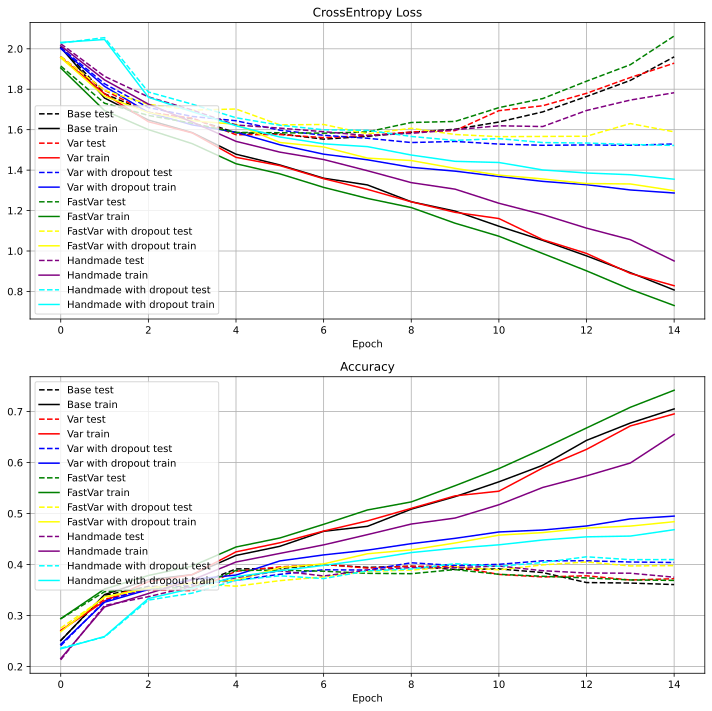

In [156]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# YOUR CODE HERE
axes[0].plot(y, test_losses_pure, linestyle = '--', color = 'Black', label = 'Base test' )
axes[0].plot(y, train_losses_pure, linestyle = '-', color = 'Black', label = 'Base train')
axes[0].plot(y, test_losses_pure_2, linestyle = '--', color = 'red', label = 'Var test' )
axes[0].plot(y, train_losses_pure_2, linestyle = '-', color = 'red', label = 'Var train')
axes[0].plot(y, test_losses_pure_3, linestyle = '--', color = 'blue', label = 'Var with dropout test' )
axes[0].plot(y, train_losses_pure_3, linestyle = '-', color = 'blue', label = 'Var with dropout train')
axes[0].plot(y, test_losses_pure_4, linestyle = '--', color = 'green', label = 'FastVar test' )
axes[0].plot(y, train_losses_pure_4, linestyle = '-', color = 'green', label = 'FastVar train')
axes[0].plot(y, test_losses_pure_5, linestyle = '--', color = 'yellow', label = 'FastVar with dropout test' )
axes[0].plot(y, train_losses_pure_5, linestyle = '-', color = 'yellow', label = 'FastVar with dropout train')
axes[0].plot(y, test_losses_pure_6, linestyle = '--', color = 'purple', label = 'Handmade test' )
axes[0].plot(y, train_losses_pure_6, linestyle = '-', color = 'purple', label = 'Handmade train')
axes[0].plot(y, test_losses_pure_7, linestyle = '--', color = 'cyan', label = 'Handmade with dropout test' )
axes[0].plot(y, train_losses_pure_7, linestyle = '-', color = 'cyan', label = 'Handmade with dropout train')

axes[0].legend()
axes[0].grid(True)
axes[0].set_xlabel('Epoch')
axes[0].set_title('CrossEntropy Loss')


axes[1].plot(y, test_accuracies_pure, linestyle = '--', color = 'Black', label = 'Base test' )
axes[1].plot(y, train_accuracies_pure, linestyle = '-', color = 'Black', label = 'Base train' )
axes[1].plot(y, test_accuracies_pure_2, linestyle = '--', color = 'red', label = 'Var test' )
axes[1].plot(y, train_accuracies_pure_2, linestyle = '-', color = 'red', label = 'Var train')
axes[1].plot(y, test_accuracies_pure_3, linestyle = '--', color = 'blue', label = 'Var with dropout test' )
axes[1].plot(y, train_accuracies_pure_3, linestyle = '-', color = 'blue', label = 'Var with dropout train')
axes[1].plot(y, test_accuracies_pure_4, linestyle = '--', color = 'green', label = 'FastVar test' )
axes[1].plot(y, train_accuracies_pure_4, linestyle = '-', color = 'green', label = 'FastVar train')
axes[1].plot(y, test_accuracies_pure_5, linestyle = '--', color = 'yellow', label = 'FastVar with dropout test' )
axes[1].plot(y, train_accuracies_pure_5, linestyle = '-', color = 'yellow', label = 'FastVar with dropout train')
axes[1].plot(y, test_accuracies_pure_6, linestyle = '--', color = 'purple', label = 'Handmade test' )
axes[1].plot(y, train_accuracies_pure_6, linestyle = '-', color = 'purple', label = 'Handmade train')
axes[1].plot(y, test_accuracies_pure_7, linestyle = '--', color = 'cyan', label = 'Handmade with dropout test' )
axes[1].plot(y, train_accuracies_pure_7, linestyle = '-', color = 'cyan', label = 'Handmade with dropout train')

axes[1].legend()
axes[1].grid(True)
axes[1].set_xlabel('Epoch')
axes[1].set_title('Accuracy')

fig.tight_layout()
plt.show()

Из этих графиков видно, что при применении Dropout качество на обучении хуже, но зато на тесте показывается более хороший результат. VAR, FastVar и Handmade показали хорошие результаты, причем FastVar еще и работал небольшое количество времени, относительно других моделей. 

## Бонус. Zoneout (2 балла)

Это еще одна модификация идеи дропаута применительно к рекуррентным нейросетям. В Zoneout на каждом временном шаге с вероятностью p компонента скрытого состояния обновляется, а с вероятностью 1-p берется с предыдущего шага. 
В Виде формул (m^t_h - бинарная маска):
 
(сначала обычный рекуррентный переход, например LSTM)
$$
i = \sigma(h_{t-1}W^i + x_t U^i+b_i) \quad
o = \sigma(h_{t-1}W^o + x_t U^o+b_o) 
$$
$$
f = \sigma(h_{t-1}W^f + x_t U^f+b_f) \quad 
g = tanh(h_{t-1} W^g + x_t U^g+b_g) 
$$
$$
c_t = f \odot c_{t-1} +  i \odot  g \quad
h_t =  o \odot tanh(c_t) \nonumber
$$
Затем Zoneout:
$$
h_t = h_t * m_h^t + h_{t-1}*(1-m_h^t)
$$
В этом методе маска уже должна быть разная во все моменты времени (иначе метод упрощается до дропаута Гала и Гарамани). На входы $x_t$ вновь можно накладывать маску до начала работы рекуррентного слоя.  

Если у вас осталось время, вы можете реализовать этот метод. Выберите основу из трех рассмотренных случаев самостоятельно.

In [149]:
class ZoneoutLSTM(torch.nn.Module):
    def __init__(self, input_size, hidden_size, dropout=0.0):
        super().__init__()
        
        self.dropout = dropout
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.input_weights = torch.nn.Linear(input_size, 4 * hidden_size)
        self.hidden_weights = torch.nn.Linear(hidden_size, 4 * hidden_size)
        
        self.reset_params()

    def reset_params(self):
        """
        Initialization as in Pytorch. 
        Do not forget to call this method!
        https://pytorch.org/docs/stable/_modules/torch/nn/modules/rnn.html#LSTM
        """
        stdv = 1.0 / np.sqrt(self.hidden_size)
        for weight in self.parameters():
            torch.nn.init.uniform_(weight, -stdv, stdv)

 
    def forward(self, x):
        # Use functions init_h0_c0 and gen_dropout_masks defined above
        # YOUR CODE HERE
        h_0, c_0 = init_h0_c0(x.shape[1], self.hidden_size, x)

        inp_m, hidd_m = gen_dropout_mask(self.input_size, self.hidden_size, self.training, self.dropout, x)

        # Implement recurrent logic to mimic torch.nn.LSTM
        # Do not forget to apply dropout mask
        # YOUR CODE HERE
        output_cell = []
        h = h_0
        c = c_0
        for k in range(x.shape[0]):
          #print('x_i', x[k].shape)# 64 32
          #print('mask_h', mask_h.shape) # 128
          #print('mask_i', mask_i.shape) # 32
          #print('h', h.shape) # 64 128
          #print('c', c.shape) # 64 128
          

          into = self.hidden_weights(h) + self.input_weights(x[k] * inp_m)
          sigm = torch.sigmoid(into[:, :3*self.hidden_size])
          i = sigm[:, :self.hidden_size]
          o = sigm[:, self.hidden_size: 2*self.hidden_size]
          f = sigm[:, 2*self.hidden_size: 3*self.hidden_size]
          
          g =  torch.tanh(into[:, 3 * self.hidden_size: 4 * self.hidden_size])
          c = f * c + i * g * hidd_m
          h1 = o * torch.tanh(c)
          #print('h1', h1.shape)
          #print('h', h.shape)
          inp_m_new, hidd_m_new = gen_dropout_mask(1, self.hidden_size, self.training, self.dropout, x)
          h = h1 *  hidd_m_new + h * (1 - hidd_m_new)

          output_cell += [h1.clone()]

        output_cell = torch.stack(output_cell)
        #print('output_cell', output_cell.shape)#[200, 64, 128]
        return output_cell, (h, c)


In [150]:
model_8 = RNNClassifier(
    embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_size=10, vocab=vocab,
    rec_layer = ZoneoutLSTM , dropout=0.25
).to(device)

In [151]:
loss_fn = torch.nn.CrossEntropyLoss(reduction='sum')#поставить summ
optimizer_8 = torch.optim.Adam(model_8.parameters(), lr=learning_rate)

In [152]:
warnings.filterwarnings('ignore')
import time 
start_time = time.time()
train_losses_pure_8, train_accuracies_pure_8, test_losses_pure_8, test_accuracies_pure_8 = train(
    train_dataloader, test_dataloader, model_8, loss_fn, optimizer_8, device, num_epochs
)
t_first_model_8 = time.time() - start_time

Epoch: 1/15. Loss (Train/Test): 2.016/2.022. Accuracy (Train/Test): 0.220/0.217
Epoch: 2/15. Loss (Train/Test): 1.983/2.005. Accuracy (Train/Test): 0.283/0.283
Epoch: 3/15. Loss (Train/Test): 1.732/1.759. Accuracy (Train/Test): 0.346/0.347
Epoch: 4/15. Loss (Train/Test): 1.652/1.692. Accuracy (Train/Test): 0.365/0.360
Epoch: 5/15. Loss (Train/Test): 1.620/1.659. Accuracy (Train/Test): 0.371/0.365
Epoch: 6/15. Loss (Train/Test): 1.576/1.633. Accuracy (Train/Test): 0.386/0.374
Epoch: 7/15. Loss (Train/Test): 1.533/1.608. Accuracy (Train/Test): 0.396/0.374
Epoch: 8/15. Loss (Train/Test): 1.503/1.585. Accuracy (Train/Test): 0.411/0.385
Epoch: 9/15. Loss (Train/Test): 1.500/1.583. Accuracy (Train/Test): 0.414/0.379
Epoch: 10/15. Loss (Train/Test): 1.449/1.553. Accuracy (Train/Test): 0.429/0.395
Epoch: 11/15. Loss (Train/Test): 1.434/1.559. Accuracy (Train/Test): 0.434/0.391
Epoch: 12/15. Loss (Train/Test): 1.412/1.539. Accuracy (Train/Test): 0.443/0.399
Epoch: 13/15. Loss (Train/Test): 1.39

In [164]:
t_first_model_8 // 60, t_first_model_8 % 60

(48.0, 55.950419664382935)

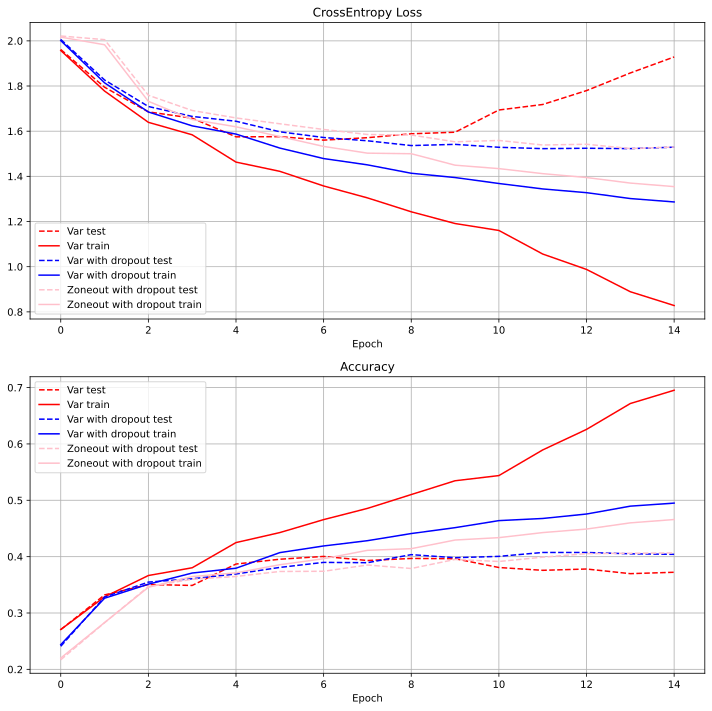

In [155]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# YOUR CODE HERE

axes[0].plot(y, test_losses_pure_2, linestyle = '--', color = 'red', label = 'Var test' )
axes[0].plot(y, train_losses_pure_2, linestyle = '-', color = 'red', label = 'Var train')
axes[0].plot(y, test_losses_pure_3, linestyle = '--', color = 'blue', label = 'Var with dropout test' )
axes[0].plot(y, train_losses_pure_3, linestyle = '-', color = 'blue', label = 'Var with dropout train')
axes[0].plot(y, test_losses_pure_8, linestyle = '--', color = 'pink', label = 'Zoneout with dropout test' )
axes[0].plot(y, train_losses_pure_8, linestyle = '-', color = 'pink', label = 'Zoneout with dropout train')


axes[0].legend()
axes[0].grid(True)
axes[0].set_xlabel('Epoch')
axes[0].set_title('CrossEntropy Loss')


axes[1].plot(y, test_accuracies_pure_2, linestyle = '--', color = 'red', label = 'Var test' )
axes[1].plot(y, train_accuracies_pure_2, linestyle = '-', color = 'red', label = 'Var train' )
axes[1].plot(y, test_accuracies_pure_3, linestyle = '--', color = 'blue', label = 'Var with dropout test' )
axes[1].plot(y, train_accuracies_pure_3, linestyle = '-', color = 'blue', label = 'Var with dropout train')
axes[1].plot(y, test_accuracies_pure_8, linestyle = '--', color = 'pink', label = 'Zoneout with dropout test' )
axes[1].plot(y, train_accuracies_pure_8, linestyle = '-', color = 'pink', label = 'Zoneout with dropout train')

axes[1].legend()
axes[1].grid(True)
axes[1].set_xlabel('Epoch')
axes[1].set_title('Accuracy')

fig.tight_layout()
plt.show()

Идея использованная в Zoneout действительно рабочая и дала неплохие результаты по сравнению с остальными моделями, однако работал дольше, 48 минут

# Часть 2. Language Modeling с помощью LSTM. (3 балла)

Во второй части мы попробуем обучить модель для генерации отзывов по их началу.

Концептуально модель будет выглядеть следующим образом:
    
![image info](https://blog.feedly.com/wp-content/uploads/2019/03/Screen-Shot-2019-03-06-at-12.08.35-PM.png)

В процессе обучения будем тренировать сеть предсказывать вероятность следующего символа при условии всех предыдущих. Эту вероятность можно моделировать с помощью скрытого состояния $h^{(t)}$ пропуская его через линейный слой с выходной размерностью равной размерности словаря:
$$
p(x^{t}|x^{t-1}, ..., x^{1}) = SoftMax(Linear(h^{(t)}))
$$

Обратите внимание, что для вычисления $p(x^{t}|x^{t-1}, ..., x^{1})$ для всех моментов времени достаточно сделать один проход по RNN, а затем применить линейное преобразование ко всем скрытым состояниям.

В качестве функции потерь необходимо использовать `CrossEntropy`.

Рассмотрим другой важный момент. Для того, чтобы решить данную задачу, модель должна уметь определять момент начала генерации предложения и оповещать о завершении генерации -- конце предложения. Для этого добавим в словарь вспомогательные токены `<sos>`, `<eos>`. Добавив `<sos>` в начало каждого предложения и `<eos>` в конец.

Модель сможет начинать генерацию как только ей будет передан токен `<sos>` и заканчивать генерацию, как только на очередном месте самым вероятным токеном оказывается `<eos>`.

Для решения этой задачи мы воспользуемся уже реализованной LSTM с дропаутом `FastRNNLayer` и классом `RNNClassifier`, то есть архитектура сети принципиально не поменяется. 

## Реализация модели и цикла обучения (1 балл)

**Не используйте циклы в `RNNLM`, `LMCrossEntropyLoss`, `LMAccuracy`**

In [478]:
class RNNLM(RNNClassifier):
    def __init__(
        self, embedding_dim, hidden_dim, vocab, dropout=0.5, layers_dropout=0.5, num_layers=1
    ):
        super().__init__(
            embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_size=len(vocab), vocab=vocab,
            rec_layer=FastRNNLayer, dropout=dropout, layers_dropout=layers_dropout, num_layers=num_layers
        )
    
    def forward(self, tokens, tokens_lens):
        """
        :param torch.tensor(dtype=torch.long) tokens: Batch of texts represented with tokens. Shape: [T, B]
        :param torch.tensor(dtype=torch.long) tokens_lens: Number of non-padding tokens for each object in batch. Shape: [B]
        :return torch.tensor: Distribution of next token for each time step. Shape: [T, B, V], V -- size of vocabulary
        """
        # Make embeddings for all tokens
        # YOUR CODE HERE
        emb = self.word_embeddings(tokens)
        
        # Forward pass embeddings through network
        # YOUR CODE HERE
        res, (a, b) = self.rnn(emb)
        # Take all hidden states from the last layer of LSTM for each step and perform linear transformation
        # YOUR CODE HERE
        res = self.output(res)
        return res

Реализуем функцию потерь для данной задачи. 

Моменты на которые нужно обратить внимание:
1. Распределение вероятности следующего токена для последнего токена в последовательности не участвует в подсчёте функции потерь.
2. Необходимо учитывать, что в одном батче могут быть тексты разной длины.

Для решения второй проблемы можно воспользоваться функцией `torch.nn.utils.rnn.pack_padded_sequence`. 

Принимая на вход батч тензоров и длину каждого тензора без учёта паддинга эта функция позволяет получить все элементы в тензорах, которые не относятся к паддингу в виде плоского массива:

In [479]:
padded_tensors = torch.tensor([
    [[1, 11, 111], [2, 22, 222], [3, 33, 333]],
    [[4, 44, 444], [5, 55, 555], [6, 66, 666]],
    [[7, 77, 777], [0, 0, 0], [8, 88, 888]],
    [[9, 99, 999], [0, 0, 0], [0, 0, 0]]
])
tensors_lens = torch.tensor([4, 2, 3])

Обратите внимание, что `torch.nn.utils.rnn.pack_padded_sequence` автоматически переупорядочивает тензоры в батче по убыванию их длины.

In [480]:
torch.nn.utils.rnn.pack_padded_sequence(padded_tensors, tensors_lens, batch_first=False, enforce_sorted=False)

PackedSequence(data=tensor([[  1,  11, 111],
        [  3,  33, 333],
        [  2,  22, 222],
        [  4,  44, 444],
        [  6,  66, 666],
        [  5,  55, 555],
        [  7,  77, 777],
        [  8,  88, 888],
        [  9,  99, 999]]), batch_sizes=tensor([3, 3, 2, 1]), sorted_indices=tensor([0, 2, 1]), unsorted_indices=tensor([0, 2, 1]))

In [459]:
class LMCrossEntropyLoss(torch.nn.CrossEntropyLoss):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def forward(self, outputs, tokens, tokens_lens):
        """
        :param torch.tensor outputs: Output from RNNLM.forward. Shape: [T, B, V]
        :param torch.tensor tokens: Batch of tokens. Shape: [T, B]
        :param torch.tensor tokens_lens: Length of each sequence in batch
        :return torch.tensor: CrossEntropyLoss between corresponding logits and tokens
        """
        # Use torch.nn.utils.rnn.pack_padded_sequence().data to remove padding and flatten logits and tokens
        # Do not forget specify enforce_sorted=False and correct value of batch_first 
        # YOUR CODE HERE
        packed_outputs = torch.nn.utils.rnn.pack_padded_sequence(outputs, tensors_lens - 1, batch_first=False, enforce_sorted=False).data
        packed_tokens = torch.nn.utils.rnn.pack_padded_sequence(tokens[1:], tensors_lens - 1, batch_first=False, enforce_sorted=False).data
        
        # Use super().forward(..., ...) to compute CrossEntropyLoss
        # YOUR CODE HERE
        res = super().forward(packed_outputs, packed_tokens)
        return res

Для оценки качества нам также необходимо вычислять долю правильно предсказанных токенов. Реализуйте класс для вычисления точности.

In [481]:
class LMAccuracy(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, outputs, tokens, tokens_lens):
        """
        :param torch.tensor outputs: Output from RNNLM.forward. Shape: [T, B, V]
        :param torch.tensor tokens: Batch of tokens. Shape: [T, B]
        :param torch.tensor tokens_lens: Length of each sequence in batch
        :return torch.tensor: Accuracy for given logits and tokens
        """
        # Use torch.nn.utils.rnn.pack_padded_sequence().data to remove padding and flatten logits and tokens
        # Do not forget specify enforce_sorted=False and correct value of batch_first 
        # YOUR CODE HERE
        packed_outputs = torch.nn.utils.rnn.pack_padded_sequence(outputs[:-1, ], tensors_lens - 1, batch_first=False, enforce_sorted=False).data
        packed_tokens = torch.nn.utils.rnn.pack_padded_sequence(tokens[1:, ], tensors_lens - 1, batch_first=False, enforce_sorted=False).data
        packed_outputs = torch.argmax(packed_outputs, axis =1)
        res = torch.sum(packed_outputs == packed_tokens)
        return res

Модифицируйте функции `train_epoch`, `evaluate`, `train` для обучения LM.

**При вычислении точности, обратите внимание на то, что мы не предсказываем первый токен в каждой последовательности и токены, относящиеся к паддингу.**

In [482]:
from torch.autograd import Variable
def train_epoch_lm(dataloader, model, loss_fn, optimizer, device):
    model.train()
    for idx, data in enumerate(dataloader):
        # 1. Take data from batch

        tokens = data['tokens'].to(device)
        tokens_lens = data['tokens_lens']
        optimizer.zero_grad()
        # 2. Perform forward pass
        forw_model = model(tokens, tokens_lens)
        # 3. Evaluate loss
        loss = loss_fn(forw_model, tokens, tokens_lens)
        #loss = Variable(loss, requires_grad = True)
        loss.backward()
        # 4. Make optimizer step
        optimizer.step()

    
def evaluate_lm(dataloader, model, loss_fn, device):
    model.eval()
    
    total_tokens = 0
    total_loss = 0.0
    total_accuracy = 0.0
    
    accuracy_fn = LMAccuracy()
    with torch.no_grad():
        for idx, data in enumerate(dataloader):
            # 1. Take data from batch
            tokens = data['tokens'].to(device)
            tokens_lens = data['tokens_lens']
            # 2. Perform forward pass
            forw_model = model(tokens, tokens_lens)
            # 3. Evaluate loss
            loss = loss_fn(forw_model, tokens, tokens_lens)
            # 4. Evaluate accuracy      
            total_loss += loss
            total_accuracy += accuracy_fn(forw_model, tokens, tokens_lens)
            total_tokens += torch.sum(tokens_lens)
   
    return total_loss / total_tokens, total_accuracy / total_tokens

def train_lm(
    train_loader, test_loader, model, loss_fn, optimizer, device, num_epochs
):
    test_losses = []
    train_losses = []
    test_accuracies = []
    train_accuracies = []
    for epoch in range(num_epochs):
        train_epoch_lm(train_loader, model, loss_fn, optimizer, device)
        
        train_loss, train_acc = evaluate_lm(train_loader, model, loss_fn, device)
        train_accuracies.append(train_acc)
        train_losses.append(train_loss)
        
        test_loss, test_acc = evaluate_lm(test_loader, model, loss_fn, device)
        test_accuracies.append(test_acc)
        test_losses.append(test_loss)
        
        print(
            'Epoch: {0:d}/{1:d}. Loss (Train/Test): {2:.3f}/{3:.3f}. Accuracy (Train/Test): {4:.3f}/{5:.3f}'.format(
                epoch + 1, num_epochs, train_losses[-1], test_losses[-1], train_accuracies[-1], test_accuracies[-1]
            )
        )
    return train_losses, train_accuracies, test_losses, test_accuracies

Теперь у нас всё готово для обучения модели.

Создадим словарь с `<sos>`, `<eos>` токенами.

Обратите внимание, что в отличие от классификации текстов нам необходимо значительно увеличить размер словаря, чтобы доля `<unk>` токенов была не велика.

Так же, так как задача генерации значительно сложнее задачи классификации текстов будем обучать модель только на префиксах рецензий длины $20$. Это позволяет значительно ускорить обучение.

In [483]:
specials = ['<pad>', '<unk>', '<sos>', '<eos>']
for special in specials:
    counter[special] = 0
lm_vocab = torchtext.vocab.Vocab(counter, specials=specials, specials_first=True, max_size=30000)

In [484]:
lm_test_dataset = LargeMovieReviewDataset(test_data_path, lm_vocab, max_len=20, pad_sos=True, pad_eos=True)
lm_train_dataset = LargeMovieReviewDataset(train_data_path, lm_vocab, max_len=20, pad_sos=True, pad_eos=True)

Создадим даталоадеры для тестовой и обучающей выборок:

In [485]:
lm_test_dataloader = DataLoader(
    lm_test_dataset, batch_size=96, shuffle=False, num_workers=3, 
    collate_fn=partial(collate_fn, padding_value=lm_vocab.lookup_indices(['<pad>'])[0])
)
lm_train_dataloader = DataLoader(
    lm_train_dataset, batch_size=96, shuffle=True, num_workers=3, 
    collate_fn=partial(collate_fn, padding_value=lm_vocab.lookup_indices(['<pad>'])[0])
)

Убедитесь, что все предложения имеют в начале `<sos>` токен, а в конце -- `<eos>` токен.

In [486]:
batch = next(iter(lm_train_dataloader))
batch['tokens'], batch['tokens_lens']

(tensor([[   2,    2,    2,  ...,    2,    2,    2],
         [ 650,  286, 6849,  ...,   29, 1231,   19],
         [6118, 7765, 6849,  ..., 2835,  282,   40],
         ...,
         [   0,    0,    0,  ...,    0,    0,    0],
         [   0,    0,    0,  ...,    0,    0,    0],
         [   0,    0,    0,  ...,    0,    0,    0]]),
 tensor([118,  49, 127, 202, 202, 124,  56,  73,  60, 129,  88,  59, 202,  44,
          58, 112,  65,  55,  34, 164, 202, 137,  55, 109, 114,  84,  19, 123,
         128, 173,  69, 165,  33, 179,  89,  85,  73,  40,  40, 202,  65,  56,
          49,  97, 140,  90, 132, 202,  90,  82, 202,  98, 105, 202, 130,  43,
         137,  48, 202,  60,  70,  61, 201, 149,  68,  29, 112,  25, 108,  60,
          79, 202, 126,  83,  61,  42,  69, 112,  96, 102,  36,  61,  51, 202,
         127,  57,  67,  32, 121,  64,  75,  64, 152, 107, 182,  82]))

Создадим модель, функцию потерь и оптимизатор: 

In [490]:
lm_model = RNNLM(
    embedding_dim=512, hidden_dim=512, vocab=lm_vocab, dropout=0.6, layers_dropout=0.6, num_layers=2
).to(device=device)

In [491]:
lm_loss_fn = LMCrossEntropyLoss(reduction='sum')
lm_optimizer = torch.optim.Adam(lm_model.parameters(), lr=0.005, weight_decay=1.2e-6)

Обучим модель:

В какой-то момент ГПУ начала вылетать по памяти, хотя раньше то же самое отрабатыало, код написан (вроде как) правильно не знаю что делать в таком случае

In [492]:
lm_train_losses, lm_train_accuracies, lm_test_losses, lm_test_accuracies = train_lm(
    lm_train_dataloader, lm_test_dataloader, lm_model, lm_loss_fn, lm_optimizer, device, 10
)

RuntimeError: ignored

## Реализация декодера. (2 балла)

Теперь, реализуем последнюю деталь -- декодирование с использованием обученной модели.
Есть несколько вариантов. Рассмотрим два самых простых:
1. **Жадное декодирование.** На каждом шаге мы выбираем токен с максимальной вероятностью и используем его для обновления скрытого состояния RNN.
2. **Top-k sampling.** На очередном шаге рассматриваются $k$ токенов с самыми большими вероятностями. Остальные токены игнорируются. Из выбранных токенов семплируется следующий токен пропорционально их вероятностям.

Прочитать подробнее про разные варианты декодирования можно по ссылкам:
1. [От huggingface](https://huggingface.co/blog/how-to-generate)
2. [На towardsdatascience](https://towardsdatascience.com/decoding-strategies-that-you-need-to-know-for-response-generation-ba95ee0faadc)

Существенным в процессе декодирования является критерий останова. Как только очередной самый вероятный символ оказался `<eos>`, то данная последовательность считается сгенерированной. Однако, может так оказаться, что `<eos>` никогда не будет выбран, тогда необходимо прекратить генерацию, как только длина последовательности перейдёт порог `max_generated_len`.

In [ ]:
def decode(model, start_tokens, start_tokens_lens, max_generated_len=20, top_k=None):
    """
    :param RNNLM model: Model
    :param torch.tensor start_tokens: Batch of seed tokens. Shape: [T, B]
    :param torch.tensor start_tokens_lens: Length of each sequence in batch. Shape: [B]
    :return Tuple[torch.tensor, torch.tensor]. Newly predicted tokens and length of generated part. Shape [T*, B], [B]
    """
    # Get embedding for start_tokens
    # YOUR CODE HERE
    embedding = self.word_embedings(start_tokens)
    
    # Pass embedding through rnn and collect hidden states and cell states for each time moment
    all_h, all_c = [], []
    h = embedding.new_zeros([model.rnn.num_layers, start_tokens.shape[1], model.hidden_dim])
    c = embedding.new_zeros([model.rnn.num_layers, start_tokens.shape[1], model.hidden_dim])
    for time_step in range(start_tokens.shape[0]):
        # YOUR CODE HERE
        pass
    
    all_h = torch.stack(all_h, dim=1)
    all_c = torch.stack(all_c, dim=1)
    # Take final hidden state and cell state for each start sequence in batch
    # We will use them as h_0, c_0 for generation new tokens
    h = all_h[:, start_tokens_lens - 1, torch.arange(start_tokens_lens.shape[0])]
    c = all_c[:, start_tokens_lens - 1, torch.arange(start_tokens_lens.shape[0])]
    
    # List of predicted tokens for each time step
    predicted_tokens = []
    # Length of generated part for each object in the batch
    decoded_lens = torch.zeros_like(start_tokens_lens, dtype=torch.long)
    # Boolean mask where we store if the sequence has already generated
    # i.e. `<eos>` was selected on any step
    is_finished_decoding = torch.zeros_like(start_tokens_lens, dtype=torch.bool)
    
    # Stop when all sequences in the batch are finished
    while not torch.all(is_finished_decoding) and torch.max(decoded_lens) < max_generated_len:
        # Evaluate next token distribution using hidden state h.
        # Note. Over first dimension h has hidden states for each layer of LSTM.
        #     We must use hidden state from the last layer
        # YOUR CODE HERE
        logits = None
        
        if top_k is not None:
            # Top-k sampling. Use only top-k most probable logits to sample next token
            indices_to_remove = logits < torch.topk(logits, top_k)[0][..., -1, None]
            # Mask non top-k logits
            logits[indices_to_remove] = -1e10
            # Sample next_token. 
            # YOUR CODE HERE
            next_token = None
        else:
            # Select most probable token
            # YOUR CODE HERE
            next_token = None
            
        predicted_tokens.append(next_token)
        
        decoded_lens += (~is_finished_decoding)
        is_finished_decoding |= (next_token == torch.tensor(model.vocab.lookup_indices(['<eos>'])[0]))

        # Evaluate embedding for next token
        # YOUR CODE HERE

        # Update hidden and cell states
        # YOUR CODE HERE

    return torch.stack(predicted_tokens), decoded_lens

Попробуем сгенерировать продолжения для нескольких префиксов:

In [ ]:
start_tokens = torch.tensor([
    lm_model.vocab.lookup_indices(['<sos>', '<pad>', '<pad>', '<pad>']),
    lm_model.vocab.lookup_indices(['<sos>', 'my', 'favorite', 'movie']),
    lm_model.vocab.lookup_indices(['<sos>', 'the', 'best', 'movie']),
    lm_model.vocab.lookup_indices(['<sos>', 'the', 'worst', 'movie']),
]).T

start_tokens_lens = torch.tensor([1, 4, 4, 4])

In [ ]:
lm_model = lm_model.cpu()
lm_model.eval()
decoded_tokens, decoded_lens = decode(lm_model, start_tokens, start_tokens_lens, max_generated_len=20, top_k=5)

In [ ]:
for text_idx in range(start_tokens.shape[1]):
    decoded_text_tokens = decoded_tokens[:decoded_lens[text_idx], text_idx]
    tokens = start_tokens[:start_tokens_lens[text_idx], text_idx].tolist() + decoded_text_tokens.tolist()
    words = np.array(lm_model.vocab.itos)[np.array(tokens)]
    print(' '.join(words))

<sos> first saw movie first time really disappointed really disappointed movie even one funniest films ever seen movie seen life <eos>
<sos> <unk> favorite movie ever seen movie really enjoyed first saw movie years ago thought would good movie <eos>
<sos> <unk> best movie ever seen movie ever made one thing bad acting bad acting bad effects bad bad script bad script bad acting
<sos> <unk> worst movie ever seen life life <unk> one best movies ever seen bad movies bad acting bad acting bad <eos>


Попробуйте выполнить семплирование для разных $k$. Сравните результаты top-k семплирования с жадным декодированием. Опишите ваши наблюдения.

In [ ]:
# YOUR CODE HERE

**Ответ:**

## Бонус. Cущественное улучшение качества. (до 3 баллов)

Та модель, которая использовалась в предыдущей части во многом заимствует улучшения LSTM из статьи [Regularizing and Optimizing LSTM Language Models](https://arxiv.org/pdf/1708.02182.pdf). Вы можете попробовать применить другие варианты регуляризации из данной статьи для существенного улучшения качества LM.

Например:
1. Dropout для эмбеддингов
2. Dropout входов и выходов RNN
3. Регуляризация активаций (AR/TAR)
4. NT-ASGD
5. Tied веса эмбеддингов и софтмакса